(file-types:notebooks)=
# Pathfinder Variational Inference

## Introduction

Pathfinder {cite:p}`zhang2021pathfinder` is a variational inference algorithm that produces samples from the posterior of a Bayesian model and compares favorably to the widely used ADVI algorithm. On large problems, it should scale better than most MCMC algorithms, including dynamic HMC (i.e., NUTS), and requires 1-2 orders of magnitude fewer log density and gradient evaluations than ADVI and dynamic HMC's warmup phase. Moreover, Pathfinder can perform the Monte Carlo KL divergence estimates used to compute ELBO in parallel, providing a major advantage over ADVI, which must evaluate the ELBO sequentially.

Like ADVI, the computational efficiencies may come at the cost of a more biased estimate of the posterior but can be managed through the algorithm's settings. For details on the algorithm, see the [arxiv preprint](https://arxiv.org/abs/2108.03782).

In this notebook, we will provide a high-level overview of the Single-path Pathfinder algorithm, Multi-path Pathfinder algorithm, how to use it with PyMC, and discuss recommended changes to the algorithm's settings after validating the model fit.

### Defining the target density

Before we go into details of each step, let's first define what we mean by a "target density" and approximating density. The target density is the posterior distribution of the model, which is given by:

$$
\begin{equation}
\begin{split}
    p(\theta \mid \mathbf{y}) &= \frac{p(\mathbf{y} \mid \theta) p(\theta)}{\int p(\mathbf{y} \mid \theta) p(\theta) d\theta} = \frac{p(\mathbf{y}, \theta)}{p(\mathbf{y})} \\
    &\propto p(\mathbf{y}, \theta)
\end{split}
\end{equation}
$$

where $p(\mathbf{y}, \theta)$ is the joint likelihood. Deriving the computationally expensive or intractable marginal likelihood $p(\mathbf{y})$, which provides the normalizing constant for the posterior distribution, is often the most challenging part of Bayesian inference since it requires integrating over $\theta$ which may be high-dimensional. An intractable marginal likelihood is often the reason for having an intractable target density.

The unnormalized target density is the joint likelihood $p(\mathbf{y}, \theta)$, but in the context of computational Bayes, we are more interested in making density evaluations of $p(\mathbf{y}, \theta)$ while leaving $\mathbf{y}$ fixed. Thus, you may also see in the variational inference literature the unnormalized target density being denoted as $p(\theta)$--which may be confusing since it is the same notation often used for the prior distribution! In this tutorial, and to simplify notation and avoid confusion, we will denote the unnormalized target density as $f(\theta)$.

### Defining a problem as intractable

Intractability in Bayesian inference is often due to the marginal likelihood $p(\mathbf{y})$ being:

1.  analytically impossible to evaluate, or
2.  computationally infeasible,
3.  difficult to sample the posterior distribution directly,

thus also making the posterior distribution intractable. The first issue can be overcome using MCMC methods. However, MCMC methods may not provide sufficient scalability to overcome the second issue when working with large datasets and high-dimensional models.

In variational inference, we instead learn an approximating density $q(\theta)$ that is as close as possible to the posterior distribution $p(\theta \mid \mathbf{y})$. The approximating density is chosen to be a family of densities that are easy to evaluate and sample from and has a closed-form. Intractability also comes from the fact that we cannot sample from the posterior distribution even if we are able to evaluate $f(\theta)$ for any $\theta$.

## Single-path Pathfinder algorithm

To help with understanding the Single-path Pathfinder algorithm, we will group parts of the algorithm into the following components/steps:

1. Generate optimization trajectory
2. Recover the approximate inverse Hessian factors
3. Evaluate log density and sample from local normal approximations
4. Calculate ELBO
5. Sample from the ELBO-maximizing normal approximation

### 1. Optimization trajectory 

Pathfinder uses L-BFGS, a quasi-Newton optimization approach that uses an approximation to the Hessian matrix, to generate an optimisation trajectory and the evaluated gradients at each point along the trajectory:

$$
\begin{equation}
\theta^{(0:L)}, g^{(0:L)} = \text{L-BFGS}(\log \bar{f}, \theta^{(0)}, J, \tau^{\text{rel}}, L^{\text{max}})
\end{equation}
$$

where:

$\theta^{(0)}$ is the initial point drawn from the initial distribution $\pi_0$, \
$\theta^{(0:L)} \in \mathbb{R}^{L+1,\text{N}}$ is the optimization trajectory, \
$\log \bar{f}$ is the negative log unnormalized density function of $f$, \
$g^{(0:L)} \in \mathbb{R}^{L+1,\text{N}}$ is the negative gradient values at each point along the trajectory, a shorter notation for $\nabla \log \bar{f} (\theta^{(0:L)})$, \
$J$ is the history size for the L-BFGS method, \
$\tau^{\text{rel}}$ is the relative tolerance for convergence of L-BFGS, \
$L^{\text{max}}$ is the maximum number of L-BFGS iterations, \
$L$ is the number of iterations to reach convergence, where $L \le L^{\text{max}}$.

The log unnormalized density $\log f$ must be evaluable and differentiable. In PyMC, when we define a model, we can easily compile the log unnormalized density function $f(\theta)$.

Starting from a random point at $\theta^{(0)}$, which should be at the tail-region of the posterior distribution, L-BFGS efficiently moves through the body of the distribution, converging to a local maximum.

### 2. Recover the approximate inverse Hessian factors

After using L-BFGS to derive an optimized exploration of the target density from an initial point, Pathfinder aims to generate local normal approximations of the target density as well as generate Monte Carlo draws from this local normal distribution to evaluate ELBO. 

The local normal approximations at point $\theta^{(l)}$ of the trajectory are obtained using techniques from the second-order Taylor series expansion:

$$
\begin{align}
\log f(\theta) &\approx \log f(\theta^{(l)}) + g^{(l)} \cdot (\theta - \theta^{(l)}) \\
& \qquad + \frac{1}{2} (\theta - \theta^{(l)})^T \cdot \text{H}(\theta^{(l)}) \cdot (\theta - \theta^{(l)}) \nonumber\\
&= \log q^{(l)}(\theta \mid \mu^{(l)}, \Sigma^{(l)})
\end{align}
$$

where $\text{H}(\theta^{(l)}) = - \nabla^2 \log f(\theta^{(l)})$ is the approximate Hessian matrix of the log unnormalized density at $\theta^{(l)}$. The mean and covariance matrix of the normal approximation $q^{(l)}(\theta | \mu^{(l)}, \Sigma^{(l)})$ are given by:

$$
\begin{align}
\mu^{(l)} &= \theta^{(l)} - \text{H}^{-1}(\theta^{(l)}) \cdot g^{(l)} \\
\Sigma^{(l)} &= \text{H}^{-1}(\theta^{(l)})
\end{align}
$$

where $\text{H}^{-1}(\theta^{(l)})$ is the approximate inverse Hessian matrix. We can think of $\mu^{(l)}, \Sigma^{(l)}$ being akin to the variational parameters of the approximating density $q^{(l)}$ at iteration $l$. Pathfinder reconstructs the factors of the inverse Hessian from the trajectory so it can sample from the normal approximations more efficiently. The covariance matrix $\Sigma^{(l)}$ can be computed from the inverse Hessian factors such that:

$$
\begin{equation}
\Sigma^{(l)} = \text{diag}(\alpha^{(l)}) + \beta^{(l)} \cdot \gamma^{(l)} \cdot \beta^{(l)\top}
\end{equation}
$$

where $\alpha^{(l)} \in \mathbb{R}^{\text{N}}$ is the diagonal of the inverse Hessian, with $\beta^{(l)} \in \mathbb{R}^{\text{N, 2J}}$ and $\gamma^{(l)} \in \mathbb{R}^{\text{2J, 2J}}$ providing the low-rank plus diagonal factorization of the inverse Hessian factor at point $\theta^{(l)}$.  Computing $\alpha^{(l)}$, $\beta^{(l)}$, and $\gamma^{(l)}$ is performed serially via the function:

$$
\begin{equation}
\alpha^{(l)}, \beta^{(l)}, \gamma^{(l)} = \text{IH-Factors}(\theta^{(0:L)}, g ^{(0:L)}, J)
\end{equation}
$$

```{note} Details on $\text{IH-Factors}$
:class: dropdown

The $\text{IH-Factors}$ function is used to recover the factors of the inverse Hessian from the trajectory.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 3: Inverse Hessian Factors}} \\
\hline
\textbf{Input:} \\
\quad \theta^{(0:L)}, ~  g^{(0:L)}, ~ J \\
\hline
\textbf{Output:} \\
\quad \alpha^{(1:L)}: \text{ diagonal elements of the approx inverse Hessian along the trajectory} \\
\quad \beta^{(1:L)}: \text{ $\beta$ factor component of the approx inverse Hessian} \\
\quad \gamma^{(1:L)}: \text{ $\gamma$ factor component of the approx inverse Hessian} \\
\hline
\textbf{IH-Factors}(\theta^{(0:L)}, g^{(0:L)}): \\
\quad \alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)} = \texttt{$\alpha$-recover}(\theta^{(0:L)}, g^{(0:L)}) \\
\quad \beta^{(1:L)}, \gamma^{(1:L)} = \texttt{$\beta\gamma$-recover}(\alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)}, J) \\
\textbf{return } ~ \alpha^{(1:L)}, \beta^{(1:L)}, \gamma^{(1:L)}
\end{array}
\end{equation*}
$$

The $\alpha\text{-recover}$ function is used to recover the diagonal elements of the inverse Hessian from the trajectory.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 4: $\alpha$-recover}} \\
\hline
\textbf{Input:} \\
\quad \theta^{(0:L)}, ~ g^{(0:L)} \\
\hline
\textbf{Output:} \\
\quad \alpha^{(1:L)} \\
\quad s^{(1:L)} \in \mathbb{R}^{L,\text{N}}: \text{ position differences between successive iterations} \\
\quad z^{(1:L)} \in \mathbb{R}^{L,\text{N}}: \text{ gradient differences between successive iterations} \\
\quad \xi^{(1:L)} \in \{0,1\}^L: \text{ mask for filtering updates} \\
\hline
\textbf{$\alpha$-recover}(x, g, \epsilon): \\
\quad \alpha_0 = \mathbf{1}_N \quad \text{\# initialize with vector of ones} \\
\quad \textbf{for } l \in 1:L \text{ do} \\
\quad \quad s^{(l)} = \theta^{(l)} - \theta^{(l-1)} \\
\quad \quad z^{(l)} = g^{(l)} - g^{(l-1)} \\
\quad \quad \textbf{if } ~ s^{(l)\top} \cdot z^{(l)} > \epsilon \Vert z \Vert^2 ~ \text{ then} \\
\quad \quad \quad a = z^{(l)\top} \cdot \text{diag}(\alpha^{(l-1)}) \cdot z^{(l)} \\
\quad \quad \quad b = z^{(l)\top} \cdot s^{(l)} \\
\quad \quad \quad c = s^{(l)\top} \cdot \text{diag}(\alpha^{(l-1)})^{-1} \cdot s^{(l)} \\
\quad \quad \quad \xi^{(l)} = 1 \\
\quad \quad \quad \textbf{for } n \in 1:N \text{ do} \\
\quad \quad \quad \quad \alpha^{(l)} = \bigg ( \frac{a}{b \cdot \alpha^{(l-1)}} + \frac{z^{(l)^2}}{b} - \frac{a \cdot s^{(l)^2}}{b \cdot c \cdot \alpha^{(l-1)^{2}}} \bigg)^{-1} \\
\quad \quad \quad \textbf{end} \\
\quad \quad \textbf{else} \\
\quad \quad \quad \alpha^{(l)} = \alpha^{(l-1)} \\
\quad \quad \quad \xi^{(l)} = 0 \\
\quad \quad \textbf{end} \\
\quad \textbf{end} \\
\textbf{return } \alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)}
\end{array}
\end{equation*}
$$

The $\beta\gamma\text{-recover}$ function is used to recover the low-rank update matrix from the trajectory.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 5: $\beta\gamma\text{-recover}$}} \\
\hline
\textbf{Input:} \\
\quad \alpha^{(1:L)}, ~ s^{(1:L)}, ~ z^{(1:L)}, ~ \xi^{(1:L)}, ~ J \\
\hline
\textbf{Output:} \\
\quad \beta^{(1:L)} \in \mathbb{R}^{L,\text{N}, 2J}: \text{ low-rank update matrix} \\
\quad \gamma^{(1:L)} \in \mathbb{R}^{L,2J,2J}: \text{ low-rank update matrix} \\
\hline
\textbf{$\beta\gamma\text{-recover}$}(\alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)}, J): \\
\quad \textbf{for } l \in 1:L \text{ do} \\
\quad \quad \xi = \text{last$\min(1,J)$ non-zero indices of } \xi^{(1:l)} \\
\quad \quad S^{(l)} = s^{(\chi)} \\
\quad \quad Z^{(l)} = z^{(\chi)} \\
\quad \quad E_{i,j}^{(l)} = \begin{cases}
S_i^{(l)\top} \cdot Z_j^{(l)} & \text{if } ~ i \leq j \quad \text{\# upper-triangular} \\
0 & \text{otherwise}
\end{cases} \\[1em]
\quad \quad \eta^{(l)} = \Big[ E_{i,j}^{(l)} \Big] \quad \text{ for } i = j \\[1em]
\quad \quad \beta^{(l)} = \bigg[\text{diag}(\alpha^{(l)}) \cdot Z^{(l)} \quad ~~ S^{(l)} \bigg] \\[1em]
\quad \quad \gamma^{(l)} = 
\begin{bmatrix}
0 & -E^{(l)^{-1}} \\[1em]
-E^{(l)^{-1}\top} & E^{(l)^{-1}\top} \cdot \Big( \text{diag}(\eta^{(l)}) + Z^{(l)\top} \cdot \text{diag}(\alpha^{(l)}) \cdot Z^{(l)} \Big) \cdot E^{(l)^{-1}}
\end{bmatrix} \\
\quad \textbf{end} \\
\quad \textbf{return } \beta^{(1:L)}, \gamma^{(1:L)}
\end{array}
\end{equation*}
$$
```

Unlike ADVI, where the covariance matrix is either diagonal (mean-field ADVI) or full rank (full-rank ADVI), Pathfinder uses a low-rank plus diagonal factorization of the inverse Hessian factor, where a larger $J$ results in a higher-rank estimate of the covariance matrix. From the $\text{IH-Factors}$, $\alpha\text{-recover}$ and $\beta\gamma\text{-recover}$ functions, we can see that the inverse Hessian approximation $\Sigma^{(l)}$ encodes the $J$-previous local curvature information collected along the optimization trajectory.

```{note} Why not use the inverse Hessian approximations from L-BFGS?
:class: dropdown

Reasons for using the inverse Hessian through its reconstruction of its factors instead of storing the inverse Hessian approximations during L-BFGS optimization are because it provides:
- Flexibility to employ a different inverse Hessian approximation than the one used in L-BFGS, allowing the Pathfinder algorithm to use other optimization methods (e.g., stochastic gradient descent with data subsampling).
- Update filtering that excludes sharp updates for inverse Hessian estimation, which filters out candidates whose gradient changes 10^12 times more than the position on the direction of the gradient update.
- Computational efficiency of log density evaluation and Monte Carlo sampling from the normal approximations when using the factors of the inverse Hessian.
```

### 3. Evaluate log density and sample from local normal approximations

After constructing the inverse Hessian factors along the optimization path, Pathfinder needs to both sample from the resulting normal approximations and evaluate the log density of these samples. This is necessary to compute the Evidence Lower Bound (ELBO) in the next step, which will allow us to select the best normal approximation.

For each iteration point $\theta^{(l)}$ in the optimization trajectory, we generate $K$ Monte Carlo samples from the local normal approximation $q^{(l)}$, denoted as and evaluates their log densities. This procedure is performed within the $\text{BFGS-Sample}$ function:

$$
\begin{equation}
\phi^{(l, 1:K)}, ~ \log q(\phi^{(l,1:K)}) = \text{BFGS-Sample}(\theta^{(l)}, g^{(l)}, \alpha^{(l)}, \beta^{(l)}, \gamma^{(l)}, K)
\end{equation}
$$

```{note} Details on $\text{BFGS-Sample}$
:class: dropdown

The $\text{BFGS-Sample}$ function is shown in below:

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 6: $\text{BFGS-Sample}$}} \\
\hline
\textbf{Input:} \\
\quad \theta^{(l)}, ~ g^{(l)}, ~ \alpha^{(l)}, ~ \beta^{(l)}, ~ \gamma^{(l)}, ~ K \\
\hline
\textbf{Output:} \\
\quad \phi^{(l, 1:K)} \in \mathbb{R}^{\text{K,N}}: \text{ samples from the local normal approximation} \\
\quad \log q(\phi^{(l,1)}), ..., \log q(\phi^{(l,K)}): \text{ log density of the samples} \\
\hline
\textbf{BFGS-Sample}(\theta^{(l)}, g^{(l)}, \alpha^{(l)}, \beta^{(l)}, \gamma^{(l)}, K): \\
\quad \quad u^{(1:K)} \sim \mathcal{N}(0, \boldsymbol{I}_{\text{N}}), \quad u^{(1:K)} \in \mathbb{R}^{\text{K,N}}\\
\quad \textbf{if } ~ 2J \ge \text{N} ~ \text{ then} \\
\quad \quad \Sigma^{(l)} = \text{diag}(\alpha^{(l)^\frac{1}{2}}) \Big( \boldsymbol{I}_{\text{N}} + \text{diag}(\alpha^{(l)^{-\frac{1}{2}}}) \cdot \beta^{(l)} \cdot \gamma^{(l)} \cdot \beta^{(l)\top} \Big) \text{diag}(\alpha^{(l)^\frac{1}{2}}) \\
\quad \quad \mu^{(l)} = \theta^{(l)} - \Sigma^{(l)} g^{(l)}\\
\quad \quad \tilde{L}^{(l)} = \text{lower-cholesky of } ~ \Sigma^{(l)} \\
\quad \quad \phi^{(l,1:K)} = \mu^{(l)} + \tilde{L} u \\ 
\quad \quad \log q(\phi^{(l,1:K)}) = -\frac{1}{2} \big( 2 \log \big\vert \tilde{L}^{(l)} \big\vert + u^\top u + \text{N}\log(2\pi) \big) \\
\quad \textbf{else} \\
\quad \quad Q \cdot \tilde{R} = \text{thin QR factorization of } ~ \text{diag}(\alpha^{(l)^{-\frac{1}{2}}}) \cdot \beta^{(l)} \\
\quad \quad \tilde{L}^{(l)} = \text{lower-cholesky of } ~ \boldsymbol{I}_{\text{N}} + \tilde{R} \gamma^{(l)} \tilde{R}^\top \\
\quad \quad \Sigma^{(l)} = \text{diag}(\alpha^{(l)}) + \beta^{(l)} \cdot \gamma^{(l)} \cdot \beta^{(l)\top} \\
\quad \quad \mu^{(l)} = \theta^{(l)} - \Sigma^{(l)} g^{(l)} \\
\quad \quad \phi^{(l,1:K)} = \mu^{(l)} + \text{diag}(\alpha^{(l)^\frac{1}{2}}) \Big( Q \cdot \tilde{L} \cdot Q^\top \cdot u + u - Q \cdot Q^\top u \Big)\\
\quad \quad \log q(\phi^{(l,1:K)}) =  -\frac{1}{2} \big( \log \big\vert \alpha^{(l)} \big\vert + 2 \log \big\vert \tilde{L}^{(l)} \big\vert \big) \\
\quad \textbf{return } \phi^{(l, 1:K)}, ~ \log q(\phi^{(l,1:K)}) \\
\\
\text{where $\phi^{(l,k)} \in \Theta$, for $k \in 1:K$. }
\end{array}
\end{equation*}
$$
```

### 4. Calculate ELBO

After sampling from each normal approximation along the optimization path, Pathfinder needs to determine which approximation best matches the target distribution. To accomplish this, we compute the ELBO for each local approximation and select the one with the highest ELBO value.

The ELBO provides a measure of the average difference, among the $K$ Monte Carlo draws, between the unnormalized log target density $\log f$ and the log approximating density $\log q^{(l)}$ for each local approximation. This can be expressed as:

$$
\begin{equation}
\begin{split}
\lambda^{(l)} = \text{ELBO}(\log f(\phi^{(l,1:K)}), \log q(\phi^{(l,1:K)})) \\
= \frac{1}{K} \sum_{k=1}^{K} \big( \log f(\phi^{(l,k)}) - \log q(\phi^{(l,k)}) \big)
\end{split}
\end{equation}
$$

and the index of the local approximation with the highest ELBO value is: 

$$
\begin{equation}
l^* = \arg \max_l \lambda^{(l)}
\end{equation}
$$

Pathfinder can efficiently evaluate the ELBO for all local approximations in parallel, in comparison to ADVI, which requires sequential ELBO evaluation. This is because Pathfinder can independently generate normal approximations at each point along the optimization trajectory, rather than iteratively updating a single approximation.

### 5. Sample from the ELBO-maximizing normal approximation

Having identified the index $l^*$ corresponding to the best normal approximation, we then draw $M$ samples from the normal approximation that maximizes the ELBO. This is done by reusing the $\text{BFGS-Sample}$ function and the index $l^*$:

$$
\begin{equation}
\psi^{(1:M)}, ~ \log q(\psi^{(1:M)}) = \text{BFGS-Sample}(\theta^{(l^*)}, g^{(l^*)}, \alpha^{(l^*)}, \beta^{(l^*)}, \gamma^{(l^*)}, M)
\end{equation}
$$

where $\psi^{(m)} \in \Theta$, for $m \in 1:M$.

### Single-path Pathfinder algorithm

Combining all the steps described above, we can now describe the Single-path Pathfinder algorithm. The pseudocode for the Single-path Pathfinder algorithm is shown in Algorithm 1.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 1: Single-path  Pathfinder}} \\
\hline
\textbf{Input:} \\
\quad \log f: \text{ log target density function} \\
\quad \pi_0: \text{ initial distribution} \\
\quad L^{\max}: \text{ max number of L-BFGS iterations} \\
\quad \tau^{\text{rel}}: \text{ relative tolerance for convergence of L-BFGS} \\
\quad J: \text{ history size for L-BFGS and inverse Hessian approximation} \\
\quad K: \text{ number of Monte Carlo draws to evaluate ELBO} \\
\quad M: \text{ number of approximate posterior draws to return} \\
\hline
\textbf{Output:} \\
\quad \psi^{(1:M)} \in \mathbb{R}^{\text{M,N}}: \text{ draws from ELBO-maximizing normal approximation} \\
\quad \log q(\psi^{(1)}),\ldots,\log q(\psi^{(M)}): \text{ log density of draws in} \\
\qquad \text{ ELBO-maximizing normal approximation} \\
\hline
\textbf{Pathfinder}(\log f, \pi_0, L, \tau^{\text{rel}}, J, K, M): \\
\quad \text{sample } \theta^{(0)} \sim \pi_0 \\
\quad \theta^{(0:L)}, \nabla \log f(\theta^{(0:L)}) = \texttt{L-BFGS}(\log f, \theta^{(0)}, J, \tau^{\text{rel}}, L^{\max}) \\
\quad \alpha^{(1:L)}, \beta^{(1:L)}, \gamma^{(1:L)} = \texttt{IH-Factors}(\theta^{(0:L)}, \nabla \log f(\theta^{(0:L)}), J) \\
\quad \textbf{for } l \in 1:L \text{ in parallel do} \\
\quad \quad \phi^{(l,1:K)}, \log q(\phi^{(l,1:K)}) = \texttt{BFGS-Sample}(\theta^{(l)}, g^{(l)}, \alpha^{(l)}, \beta^{(l)}, \gamma^{(l)}, K) \\
\quad \quad \textbf{for } k \in 1:K \text{ do} \\
\quad \quad \quad \text{eval and store } \log f(\phi^{(l,k)}) \\
\quad \quad \textbf{end} \\
\quad \quad \lambda^{(l)} = \text{ELBO}(\log f(\phi^{(l,1:K)}), \log q(\phi^{(l,1:K)})) \\
\quad \textbf{end} \\
\quad l^* = \arg \max_l \lambda^{(l)} \\
\quad \psi^{(1:M)}, \log q(\psi^{(1:M)}) = \texttt{BFGS-Sample}(\theta^{(l^*)}, g^{(l^*)}, \alpha^{(l^*)}, \beta^{(l^*)}, \gamma^{(l^*)}, M) \\
\textbf{return } ~ \psi^{(1:M)}, ~ \log q(\psi^{(1:M)})
\end{array}
\end{equation*}
$$

```{admonition} Clarity on the parameter notations
:class: dropdown

So far, we have used the $\theta^{(l)}, \phi^{(k)}, \psi^{(m)} \in \Theta$ notations to denote the model parameter. The reason for this is to distinguish between the candidate parameters $\theta^{(l)}$ along the optimization trajectory, the Monte Carlo samples $\phi^{(k)}$ from the local normal approximations, and the ELBO-maximizing normal approximation $\psi^{(m)}$.
```

## Multi-path Pathfinder algorithm

The Multi-path Pathfinder algorithm extends the single-path version by running multiple instances of Pathfinder in parallel from different initialization points, followed by importance resampling to select the final set of draws. The Multi-path Pathfinder algorithm pseudocode is shown in Algorithm 2.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 2: Multi-path  Pathfinder}} \\
\hline
\textbf{Input:} \\
\quad \log f: \text{ log target density function} \\
\quad \pi_0: \text{ initial distribution} \\
\quad L^{\max}: \text{ max number of L-BFGS iterations} \\
\quad \tau^{\text{rel}}: \text{ relative tolerance for convergence of L-BFGS} \\
\quad J: \text{ history size for L-BFGS and inverse Hessian approximation} \\
\quad K: \text{ number of Monte Carlo draws to evaluate ELBO} \\
\quad M: \text{ number of draws returned by each Pathfinder} \\
\quad I: \text{ number of independent Pathfinders} \\
\quad R: \text{ number of draws returned by importance sampling} \\
\hline
\textbf{Output:} \\
\quad \widetilde{\theta}^{(1:R)} \in \mathbb{R}^{\text{R,N}}: \text{ draws from the approximate posterior distribution} \\
\hline
\textbf{Multi-Path Pathfinder}(\log f, \pi_0, L, \tau^{\text{rel}}, J, K, M, I, R): \\
\quad \textbf{for } i \in 1:I \text{ in parallel do} \\
\quad \quad \psi^{(i, 1:M)}, \log q(\psi^{(i, 1:M)}) = \texttt{Pathfinder}(\log f, \pi_0, L, \tau^{\text{rel}}, J, K, M) \\
\quad \quad \text{eval } \log f(\psi^{(i,1)}), \ldots, \log f(\psi^{(i,M)}) \\
\quad \textbf{end} \\
\quad \widetilde{\theta}^{(1)},\ldots,\widetilde{\theta}^{(R)} = \texttt{IM-Sampling}(\psi^{(1:I, 1:M)}, \log f(\psi^{(1:I, 1:M)}), \log q(\psi^{(1:I, 1:M)}), R) \\
\textbf{return } ~ \widetilde{\theta}^{(1:R)} \\
\\
\text{where $\widetilde{\theta}^{(r)} \in \Theta$, for $r \in 1:R$.}
\end{array}
\end{equation*}
$$

### Importance sampling

We use importance sampling to select the final set of draws from all the multiple runs of the Single-path algorithm, allowing us to capture multimodality, and other non-normal characteristics of the target posterior distribution.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 8: Importance Sampling}} \\
\hline
\textbf{Input:} \\
\quad \psi^{(1:I, 1:M)}, \log f(\psi^{(1:I, 1:M)}), \log q(\psi^{(1:I, 1:M)}), R \\
\hline
\textbf{Output:} \\
\quad \widetilde{\theta}^{(1:R)} \in \mathbb{R}^{\text{R,N}}: \text{ draws from the approximate posterior distribution} \\
\hline
\textbf{IM-Sampling}(\psi^{(1:I, 1:M)}, \log f(\psi^{(1:I, 1:M)}), \log q(\psi^{(1:I, 1:M)}), R): \\[0.1em]
\quad S = I \times M, \quad S \in \mathbb{N} \\
\quad r^{(1:S)} = \text{flatten} ~ \log f(\psi^{(1:I, 1:M)}) - \log q(\psi^{(1:I, 1:M)}) - 2\log(I) , \quad r \in \mathbb{R}^{\text{S}} \\
\quad w^{(1:S)} = \text{PSIS}(r^{(1:S)}) \\
\quad \widetilde{\theta}^{(1:R)} = \text{ randomly select from } \psi^{(1:I, 1:M)} \text{ with probabilities} \\
\quad \text{proportionate to } w^{(1:S)} \\
\textbf{return } ~ \widetilde{\theta}^{(1:R)} \\
\\
\text{where $\widetilde{\theta}^{(r)} \in \Theta$, and $\text{PSIS}$ is the Pareto-Smoothed Importance} \\
\text{Sampling weights from [ref paper].}
\end{array}
\end{equation*}
$$

The importance sampling step used in [ref paper] used random selection with replacement. However, within the PyMC implementation, the default implementation uses without replacement. This is because we have determined that sampling without replacement provides more stable results that are generally closer to approximation using NUTS.

## Application

PyMC's implementation of Pathfinder is now natively integrated using PyTensor. The Pathfinder implementation can be accessed through [pymc-extras](https://github.com/pymc-devs/pymc-extras/), which can be installed via:

`pip install git+https://github.com/pymc-devs/pymc-extras`

In [2]:
import os

import numpy as np
import pandas as pd
import pymc as pm
import pymc_extras as pmx
import pytensor.tensor as pt
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import preliz as pz

# configure matplotlib
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.figsize": (6, 3.3),
        "axes.edgecolor": "black",
        "axes.linewidth": 0.35,
        "axes.facecolor": "white",
        "font.size": 8,
        "lines.linewidth": 0.9,
        "lines.markersize": 4,
        "lines.markeredgecolor": "k",
        "lines.markeredgewidth": 0.6,
    }
)

# set arviz style
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = 'retina'
seed = sum(map(ord, "pathfinder"))
rng = np.random.default_rng(seed)

In [3]:
def plot_results(results, plot_arviz=False, var_names=None, **plot_kwargs):
    if isinstance(results, dict):
        results_az_dict = {
            key: az.extract(value, var_names=var_names, keep_dataset=True)
            for key, value in results.items()
        }
    else:
        results_az_dict = {"results": az.extract(results)}
        results = {"results": results}

    num_subplots = 0
    for key, results_az in results_az_dict.items():
        for var_name, var_data in results_az.data_vars.items():
            dims = var_data.dims
            if dims == ("sample",):
                num_subplots += 1
            else:
                coord_names = var_data.coords[dims[0]].values
                num_subplots += len(coord_names)
        break

    ncols = min(5, num_subplots)
    nrows = (num_subplots + ncols - 1) // ncols
    figsize = (ncols * 3.3, nrows * 3.1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if isinstance(axes, np.ndarray):
        ax = axes.flat
    else:
        ax = [axes]

    default_kwargs = {"fill": True, "alpha": 0.35, "linewidth": 1}
    plot_kwargs = default_kwargs | plot_kwargs

    for key, results_az in results_az_dict.items():
        i = 0
        for var_name, var_data in results_az.data_vars.items():
            dims = var_data.dims
            if len(dims) == 1:
                sns.kdeplot(
                    var_data.data.ravel(),
                    ax=ax[i],
                    **plot_kwargs,
                )
                ax[i].set_title(var_name)
                i += 1
            else:
                for dim in dims:
                    if dim != "sample":
                        coord_names = var_data.coords[dim].values
                        for coord_name in coord_names:
                            data = var_data.loc[{dim: coord_name}].data
                            sns.kdeplot(
                                data.ravel(),
                                ax=ax[i],
                                **plot_kwargs,
                            )
                            ax[i].set_title(f"{var_name}[{coord_name}]")
                            i += 1

    handles = []
    for c, (key, results_az) in enumerate(results_az_dict.items()):
        handles.append(
            plt.Line2D(
                [0],
                [0],
                color=sns.color_palette()[c],
                lw=4,
                label=f"(sns): {key}",
                alpha=0.5,
            )
        )
        if plot_arviz:
            try:
                az.plot_density(
                    results[key],
                    var_names=list(results_az.data_vars.keys()),
                    colors="k",
                    shade=0.15,
                    textsize=8,
                    ax=ax,
                )
                handles.append(
                    plt.Line2D(
                        [0], [0], color="k", lw=4, label=f"(arviz): {key}", alpha=0.5
                    )
                )
            except Exception as e:
                print(f"ArviZ plotting failed: {str(e)}")

    # create a single legend at the bottom outside the axes
    fig.legend(
        handles=handles,
        loc="lower center",
        ncol=len(handles),
        bbox_to_anchor=(0.5, -0.15),
        fontsize=20,
    )

    for axis in ax:
        axis.set_ylabel("")
        axis.set_yticks([])
        axis.set_yticklabels([])

    for j in range(i, len(ax)):
        ax[j].axis("off")

    plt.show()

## Eight Schools example

In [3]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [4]:
with pm.Model(coords={"school": np.arange(J)}) as model:
    baseline = pm.Normal("baseline", mu=0.0, sigma=10.0)
    school_sd = pm.HalfCauchy("school_sd", 5.0)

    school_offset = pm.Normal("school_offset", mu=0, sigma=1, dims="school")
    _ = pm.Normal(
        "obs",
        mu=baseline + school_sd * school_offset,
        sigma=sigma,
        observed=y,
        dims="school",
    )

In [5]:
with model:
    idata_nuts = pm.sample(nuts_sampler="nutpie", random_seed=rng)
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=rng)
    idata_pf = pmx.fit(method="pathfinder", random_seed=rng)

Output()

Finished [100%]: Average Loss = 32.399
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectori

Output()

Pathfinder Results                          
                                            
  No. model parameters     10               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 15 ± std 2  
                                            
  Path Status:                              
  SUCCESS                  3                
  ELBO_ARGMAX_AT_ZERO      1                
  ELBO argmax              mean 2 ± std 1   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.73             
                                            
  Timing (seconds):                         
  Compile                  7.89             
  Compute                  0.04             
  Total                    7.92             

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.

Let's compare the results:

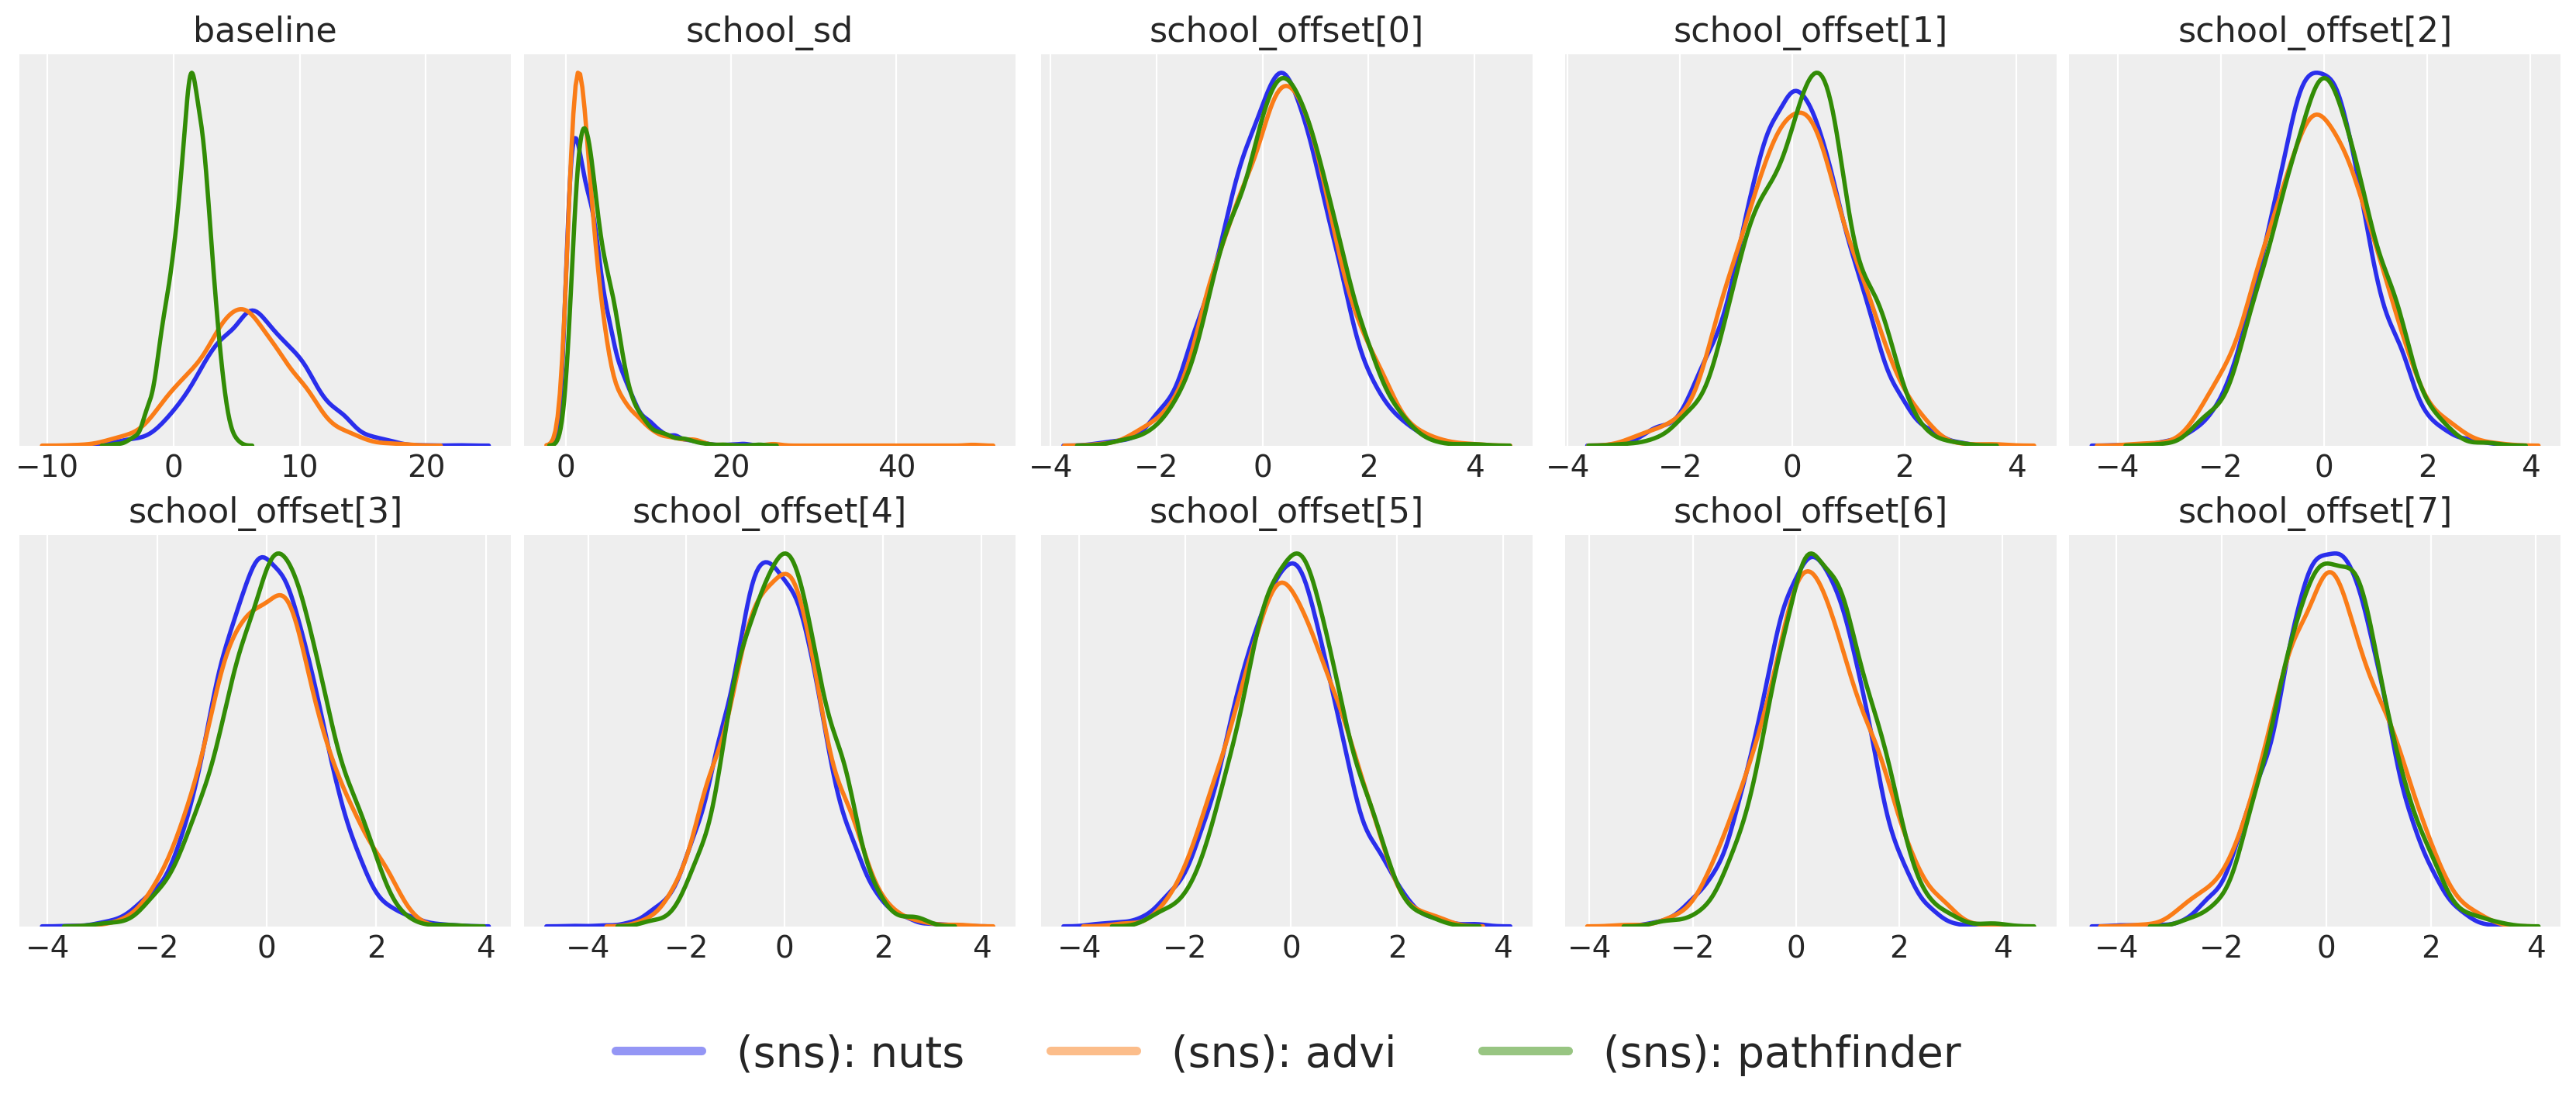

In [6]:
var_names = [RV.name for RV in model.free_RVs]
res = {"nuts": idata_nuts, "advi": idata_advi, "pathfinder": idata_pf}

plot_results(res, fill=False, linewidth=2, alpha=1, var_names=var_names)

It looks ADVI does a better job than Pathfinder out of the box. However, we can tune Pathfinder's hyper-parameters, to get a better approximation -- namely, by increasing the jitter of the different paths, and / or increasing the number of paths:

In [7]:
with model:
    idata_jitter_pf = pmx.fit(
        method="pathfinder",
        jitter=10.0,
        random_seed=rng,
    )

    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder",
        num_paths=50,
        jitter=10.0,
        random_seed=rng,
    )

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                           
                                             
  No. model parameters     10                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    7                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   10.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                4                 
  L-BFGS iterations        mean 25 ± std 13  
                                             
  Path Status:                               
  SUCCESS                  4                 
  ELBO argmax              mean 14 ± std 13  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 0.96              
                                             
  Timing (seconds):                          
  Compile                  2.67              
  Compute                  0.04              
  Total                    2.71

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                           
                                             
  No. model parameters     10                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    7                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   10.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 27 ± std 10  
                                             
  Path Status:                               
  SUCCESS                  49                
  ELBO_ARGMAX_AT_ZERO      1                 
  ELBO argmax              mean 11 ± std 9   
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 0.79              
                                             
  Timing (seconds):                          
  Compile                  2.04              
  Compute                  0.49              
  Total                    2.53              

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.

We get a warning for the increased-paths version, where one path didn't converge because it was initialized in a high-density region of the target distribution, which makes it difficult to explore the parameter space. We should increase jitter if this occurrence is high relative to the number of paths, but it's not here (1/50), so we can safely go ahead, and compare the results again, this time focusing on `baseline`, the only problematic parameter:

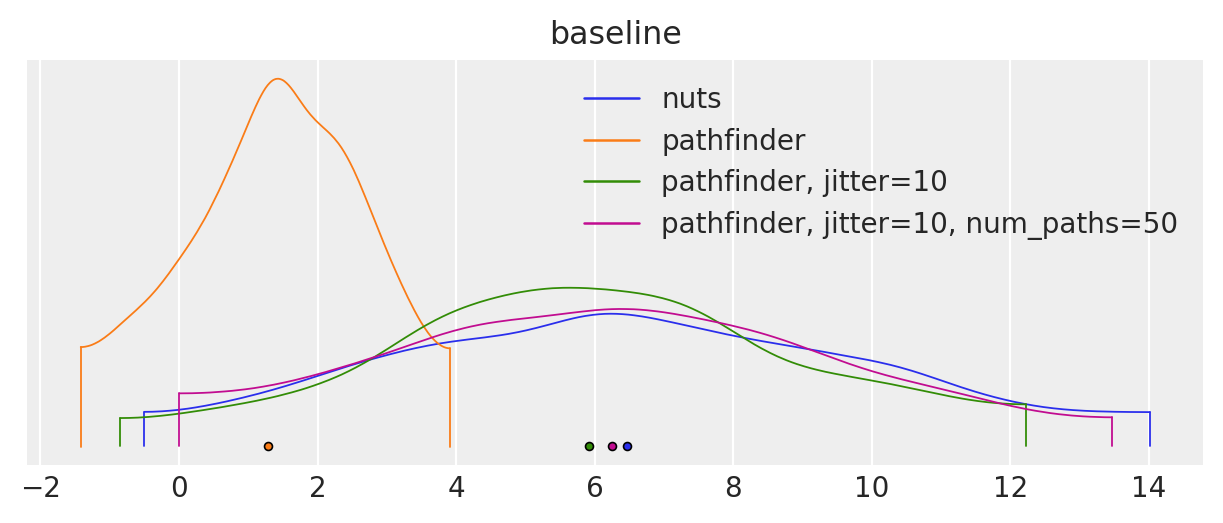

In [8]:
az.plot_density(
    [idata_nuts, idata_pf, idata_jitter_pf, idata_jitter_paths_pf],
    data_labels=[
        "nuts",
        "pathfinder",
        "pathfinder, jitter=10",
        "pathfinder, jitter=10, num_paths=50",
    ],
    var_names=["baseline"],
    figsize=(6, 2.5),
    textsize=10,
);

All this been said, let's not forget inference results are always an interaction of the data, sampler and model. It turns out there is actually room for improvement in our previous model:

1. It is over-parametrized: we have 9 parameters to estimate schools' behavior (one `baseline` + eight `school_offsets`), when there are only 8 schools. We should either constrain one school offset to 0 (aka reference encoding) or constrain the sum of school offsets to 0 (which is enforced by `ZeroSumNormal`. See [this](https://learnbayesstats.com/episode/74-optimizing-nuts-developing-zerosumnormal-distribution-adrian-seyboldt) for more details).

2. The HalfCauchy is a very wide prior on the standard deviation of the population of schools, basically encoding that it's possible that schools are so different from each other that knowing about one doesn't tell us much about the others. This is rarely the case, especially in the social sciences, so using a prior that places less density on very high standard deviations (while still avoiding the problematic value of 0) makes more sense a priori. The following plot shows such a prior:

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:288: RuntimeWarning: invalid value encountered in nb_logpdf
  return super().__call__(*args, **kws)


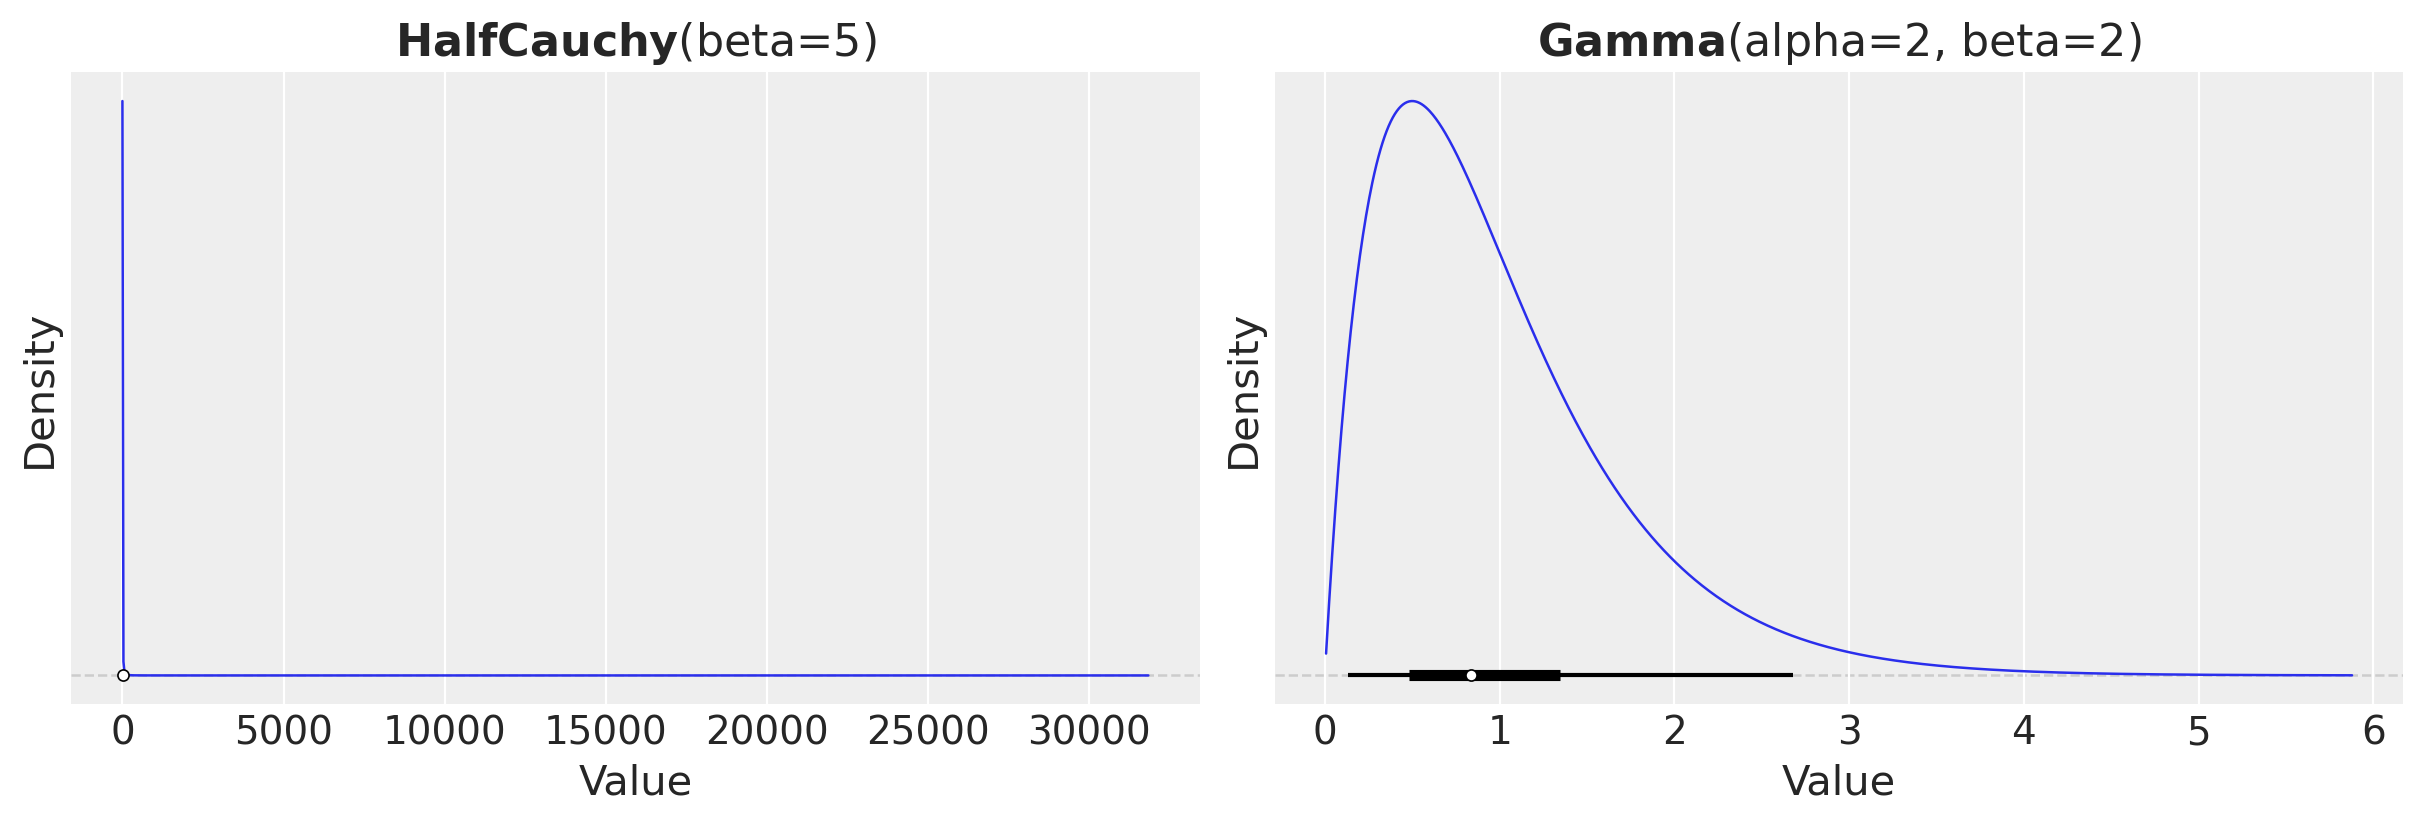

In [9]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

pz.HalfCauchy(beta=5).plot_pdf(ax=axes[0], legend="title", pointinterval=True)
axes[0].set(xlabel="Value", ylabel="Density")

pz.Gamma(alpha=2, beta=2).plot_pdf(ax=axes[1], legend="title", pointinterval=True)
axes[1].set(xlabel="Value", ylabel="Density");

Taking all this into account, here is our updated model:

In [10]:
with pm.Model(coords={"school": np.arange(J)}) as model:
    baseline = pm.Normal("baseline", mu=0.0, sigma=10.0)
    school_sd = pm.Gamma("school_sd", 2, 2)
    school_offset = pm.ZeroSumNormal("school_offset", dims="school")

    _ = pm.Normal(
        "obs",
        mu=baseline + school_sd * school_offset,
        sigma=sigma,
        observed=y,
        dims="school",
    )

    idata_nuts = pm.sample(nuts_sampler="nutpie", random_seed=rng)
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=rng)
    idata_pf = pmx.fit(method="pathfinder", random_seed=rng)

Output()

Finished [100%]: Average Loss = 31.142
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectori

Output()

Pathfinder Results                          
                                            
  No. model parameters     9                
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 10 ± std 1  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 7 ± std 2   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.60             
                                            
  Timing (seconds):                         
  Compile                  4.89             
  Compute                  0.04             
  Total                    4.93

And now, here is what we get:

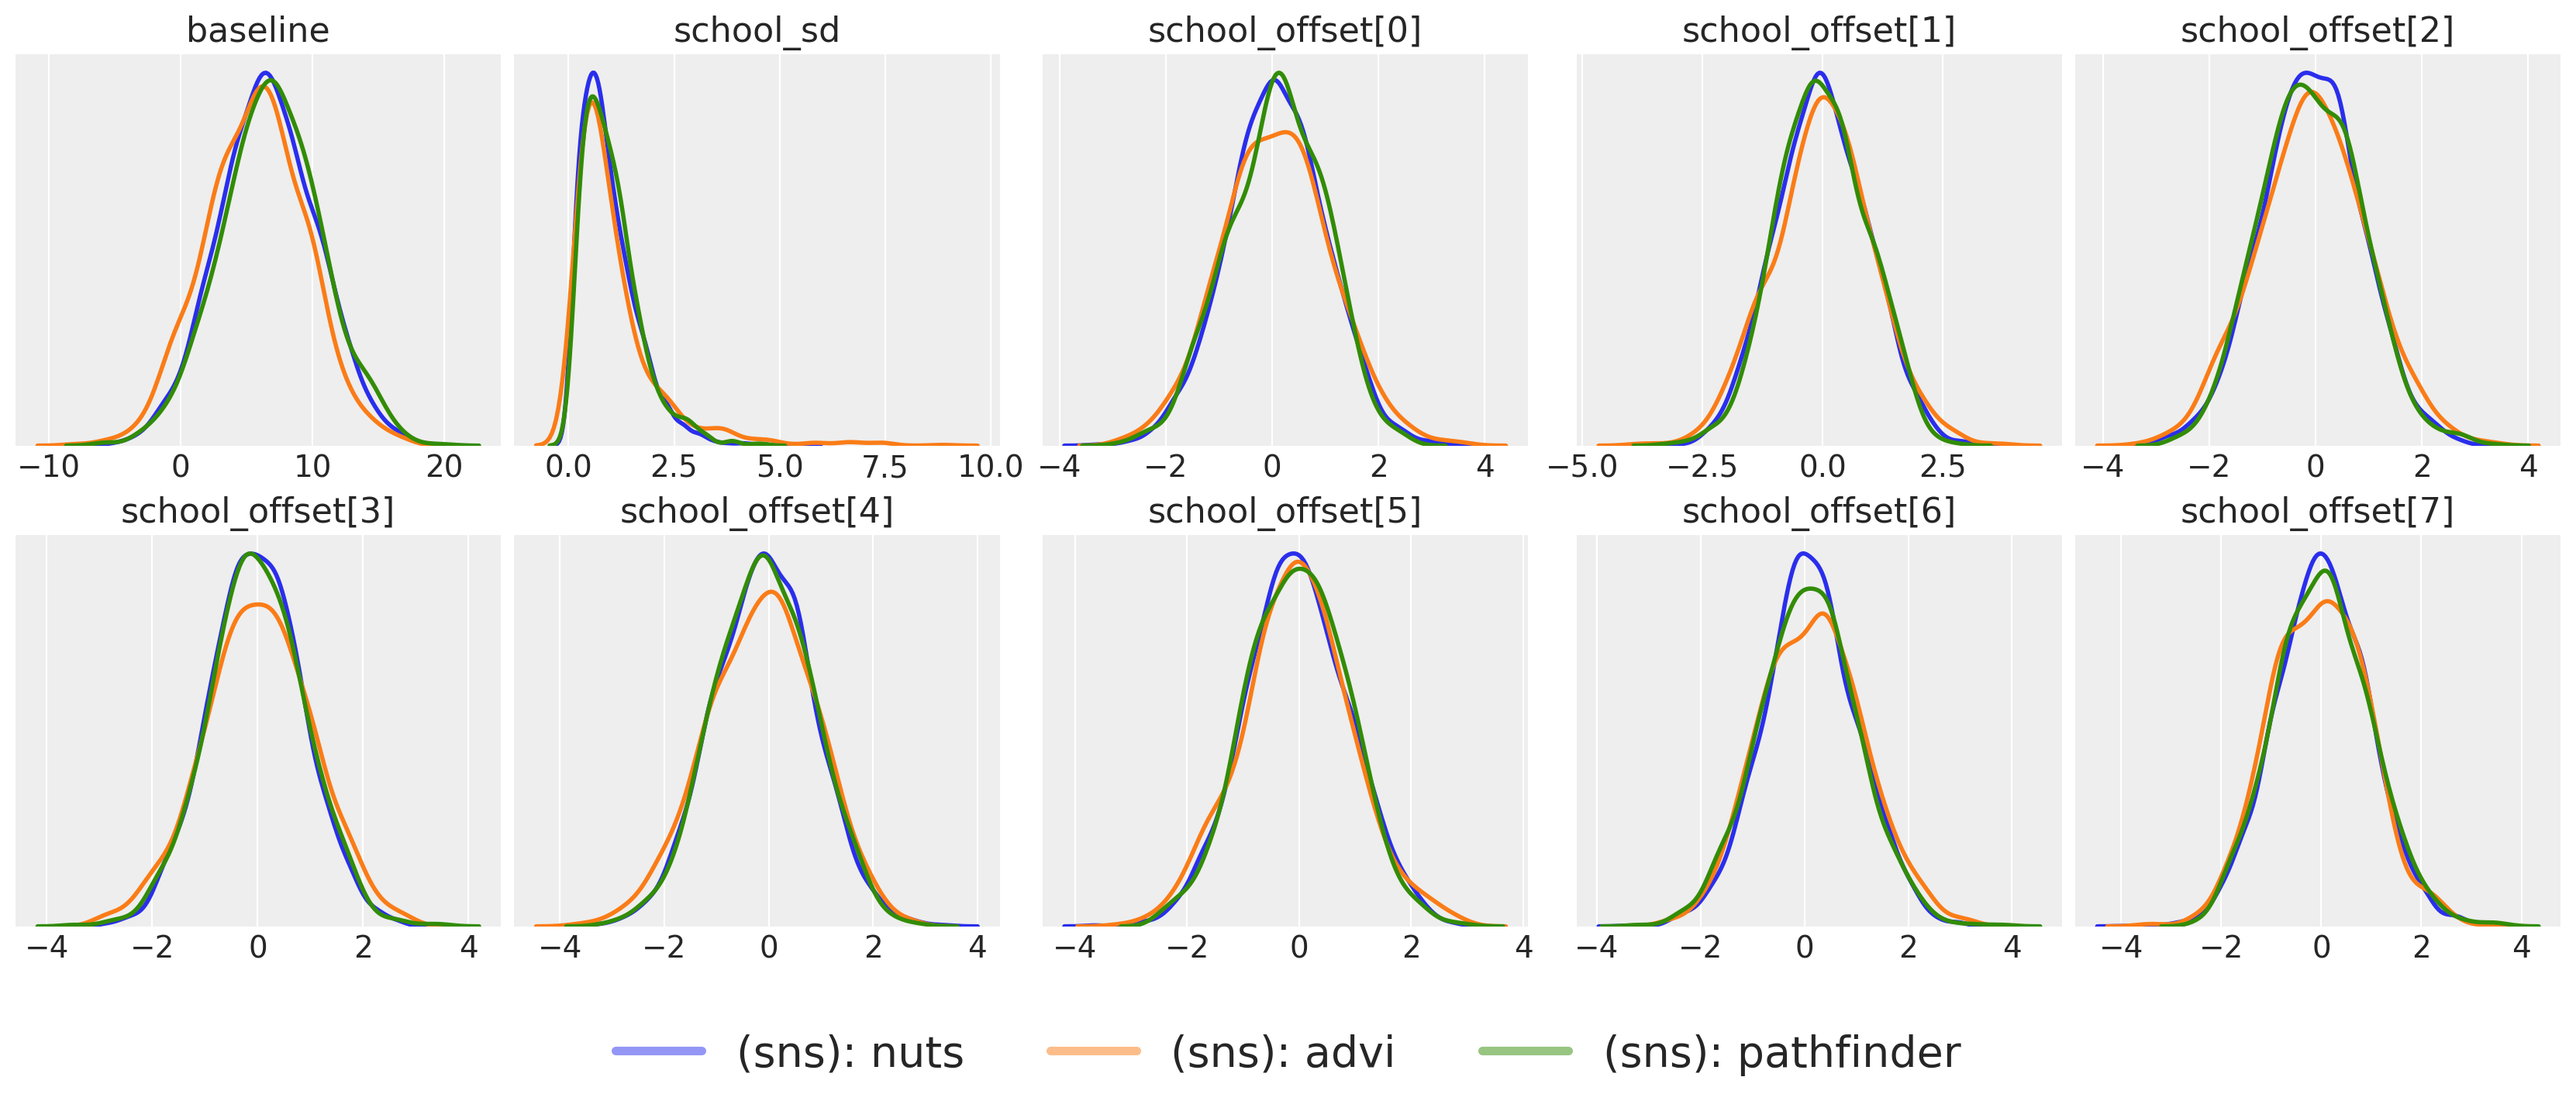

In [11]:
var_names = [RV.name for RV in model.free_RVs]
res = {"nuts": idata_nuts, "advi": idata_advi, "pathfinder": idata_pf}

plot_results(res, fill=False, linewidth=2, alpha=1, var_names=var_names)

## Rugby example - Hierarchical Poisson Regression

See [this tutorial](https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html) for details about the model.

In [12]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

In [13]:
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"match": df_all.index, "team": teams}

In [14]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims="match",
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims="match",
    )

In [16]:
with model:
    idata_nuts = pm.sample(
        nuts_sampler="nutpie",
        random_seed=rng,
    )
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=rng)
    idata_pf = pmx.fit(method="pathfinder", random_seed=rng)

Output()

Finished [100%]: Average Loss = 557.58
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectori

Output()

Pathfinder Results                           
                                             
  No. model parameters     16                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    9                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   2.0               
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                4                 
  L-BFGS iterations        mean 44 ± std 12  
                                             
  Path Status:                               
  SUCCESS                  4                 
  ELBO argmax              mean 28 ± std 9   
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 1.11              
                                             
  Timing (seconds):                          
  Compile                  1.93              
  Compute                  0.13              
  Total                    2.06

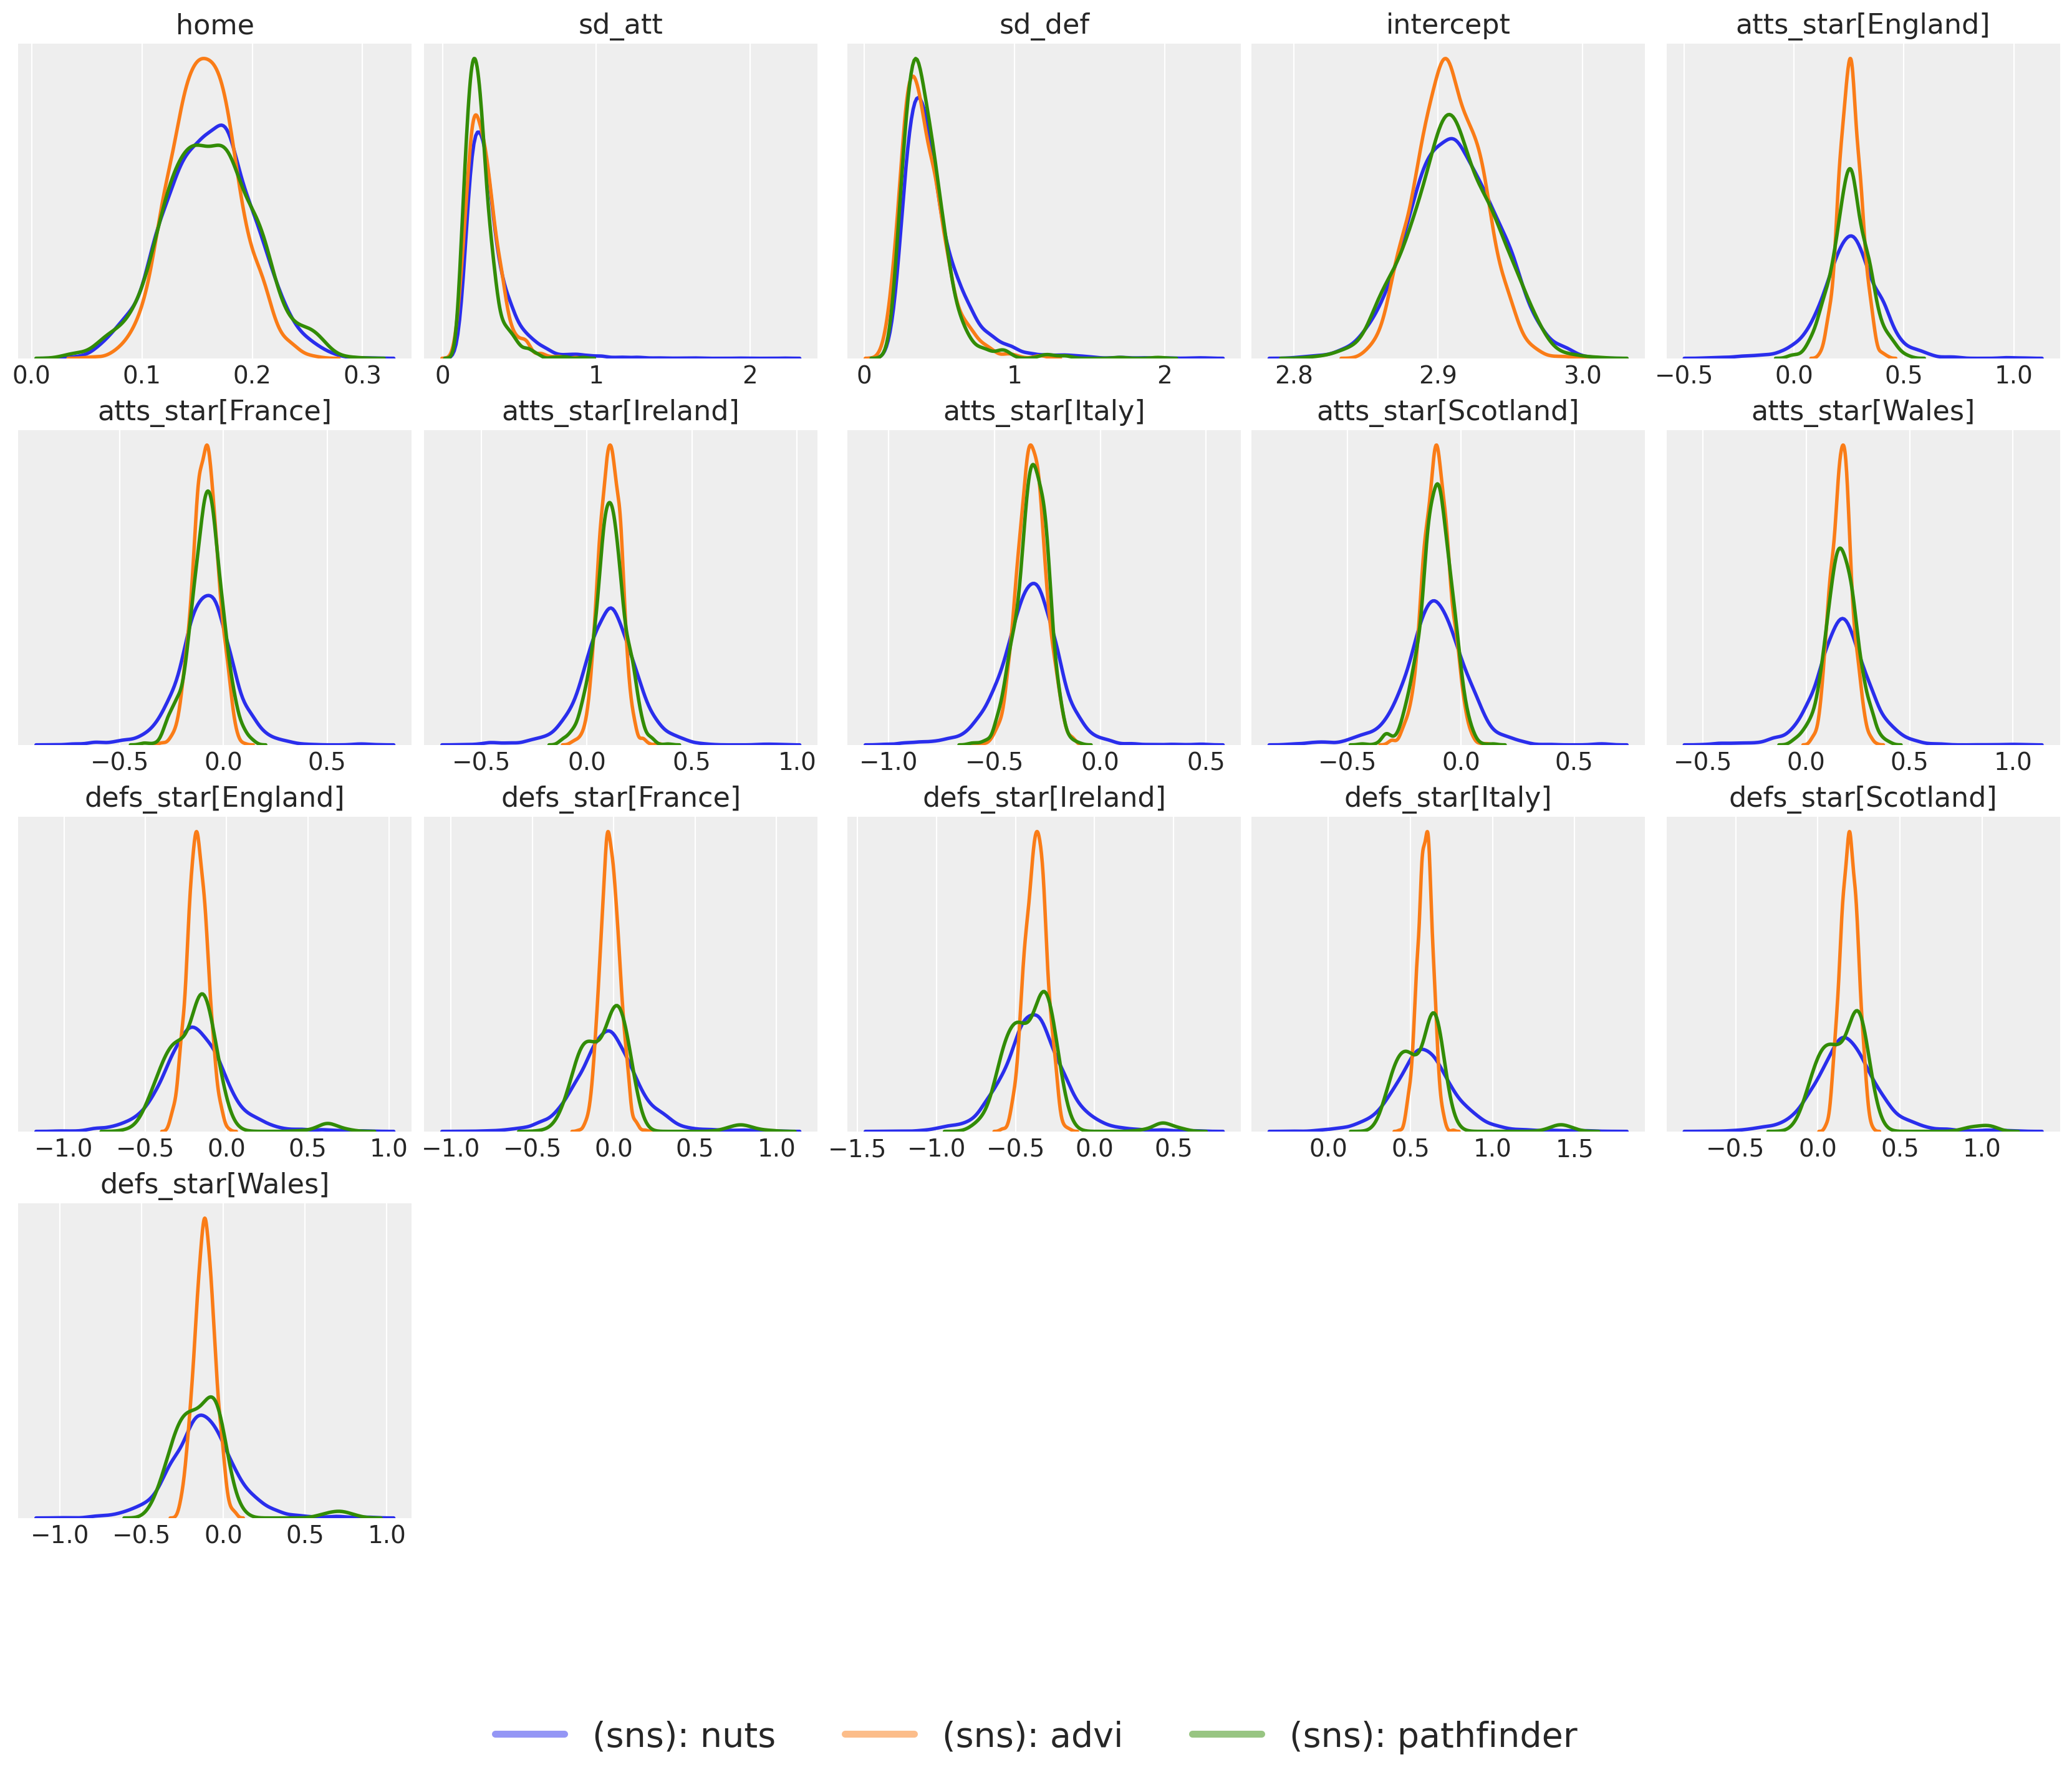

In [17]:
var_names = [RV.name for RV in model.free_RVs]
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res, var_names=var_names, fill=False, linewidth=2, alpha=1)

In [18]:
with model:
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=rng
    )

res["pf-jitter-paths"] = idata_jitter_paths_pf

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                            
                                              
  No. model parameters     16                 
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    9                  
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   20.0               
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                50                 
  L-BFGS iterations        mean 101 ± std 26  
                                              
  Path Status:                                
  SUCCESS                  50                 
  ELBO argmax              mean 92 ± std 26   
                                              
  Importance Sampling:                        
  Method                   psis               
  Pareto k                 1.10               
                                              
  Timing (seconds):                           
  Compile                  2.48               
  Compute                  2.42               
  Total                    4.90

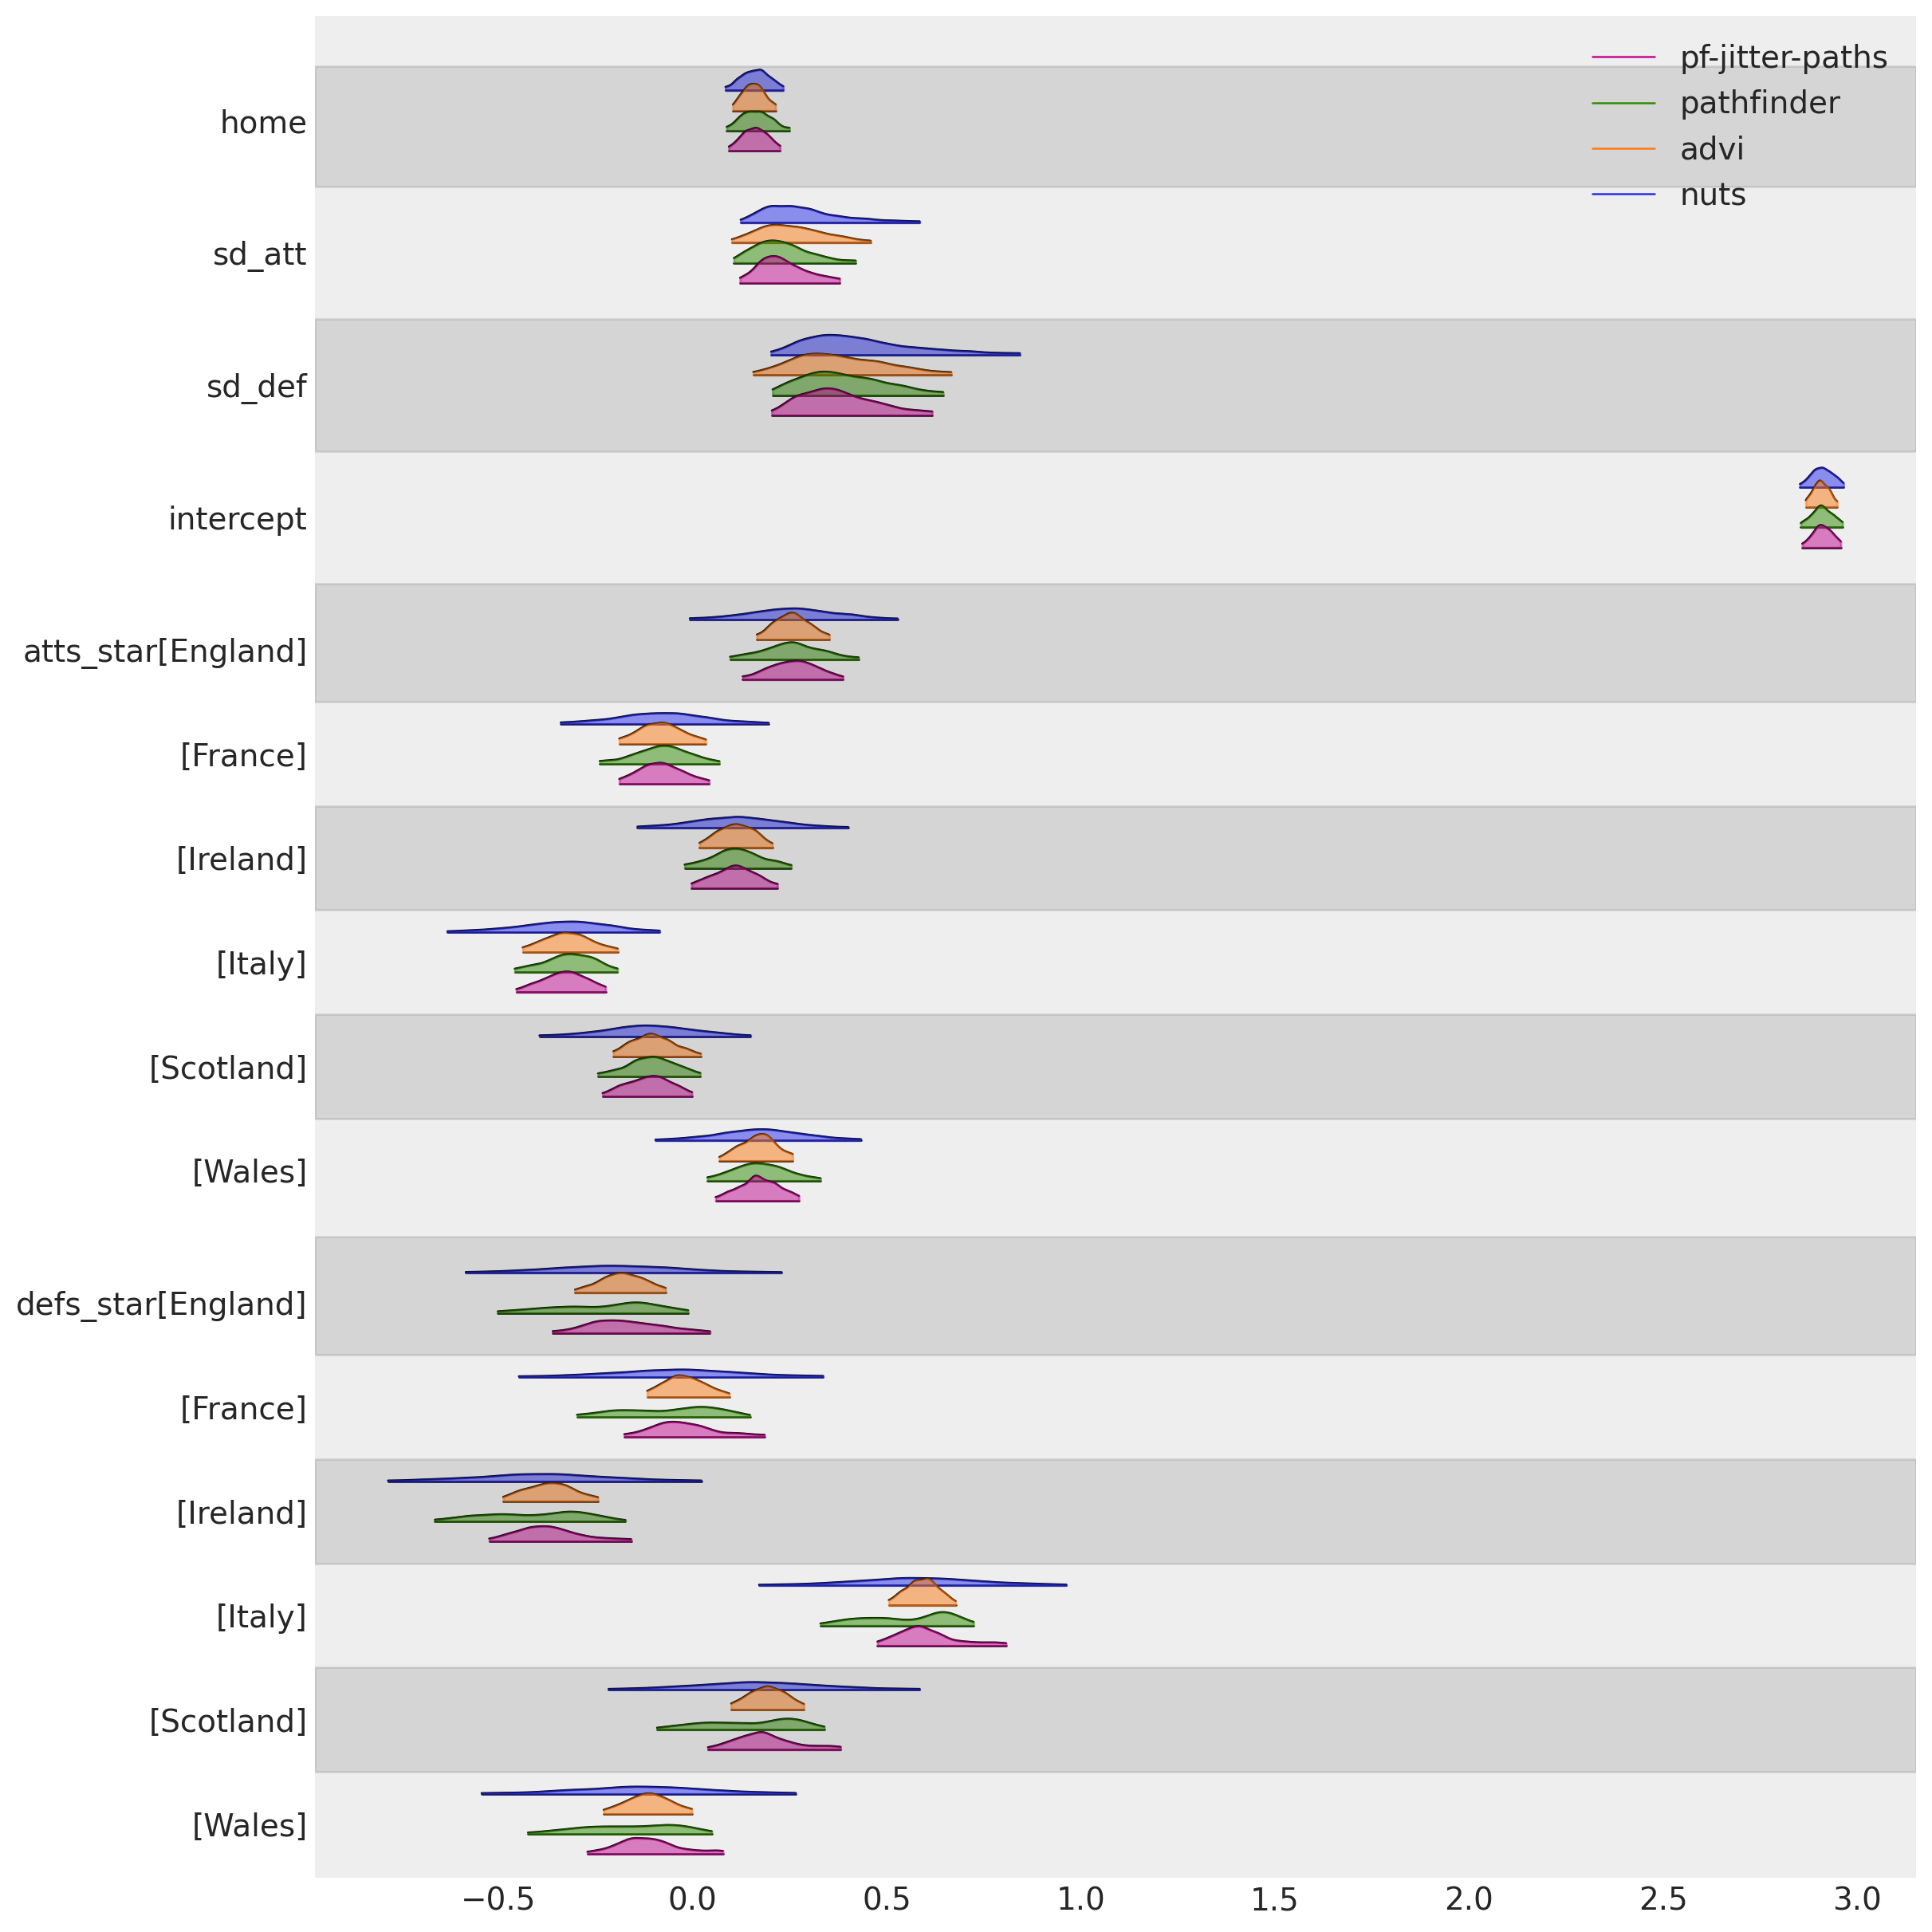

In [19]:
az.plot_forest(
    [idata for idata in res.values()],
    model_names=[name for name in res.keys()],
    var_names=var_names,
    combined=True,
    figsize=(12, 12),
    kind="ridgeplot",
    ridgeplot_alpha=0.5,
);

## Cherry Blossoms - Spline Regression

In [20]:
from patsy import dmatrix
from pathlib import Path

try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots + 2))[1:-1]

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=False) - 1",
    {"year": blossom_data.year.to_numpy(), "knots": knot_list},
)

spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

In [21]:
COORDS = {"splines": np.arange(B.shape[1])}

with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")

    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu=mu, sigma=sigma, observed=blossom_data.doy)

    idata_nuts = pm.sample(nuts_sampler="nutpie", random_seed=rng)
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=rng)
    idata_pf = pmx.fit(method="pathfinder", random_seed=rng)

Output()

Finished [100%]: Average Loss = 2,681.6
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vector

Output()

Pathfinder Results                          
                                            
  No. model parameters     20               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 30 ± std 4  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 22 ± std 4  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.12             
                                            
  Timing (seconds):                         
  Compile                  4.34             
  Compute                  0.08             
  Total                    4.42

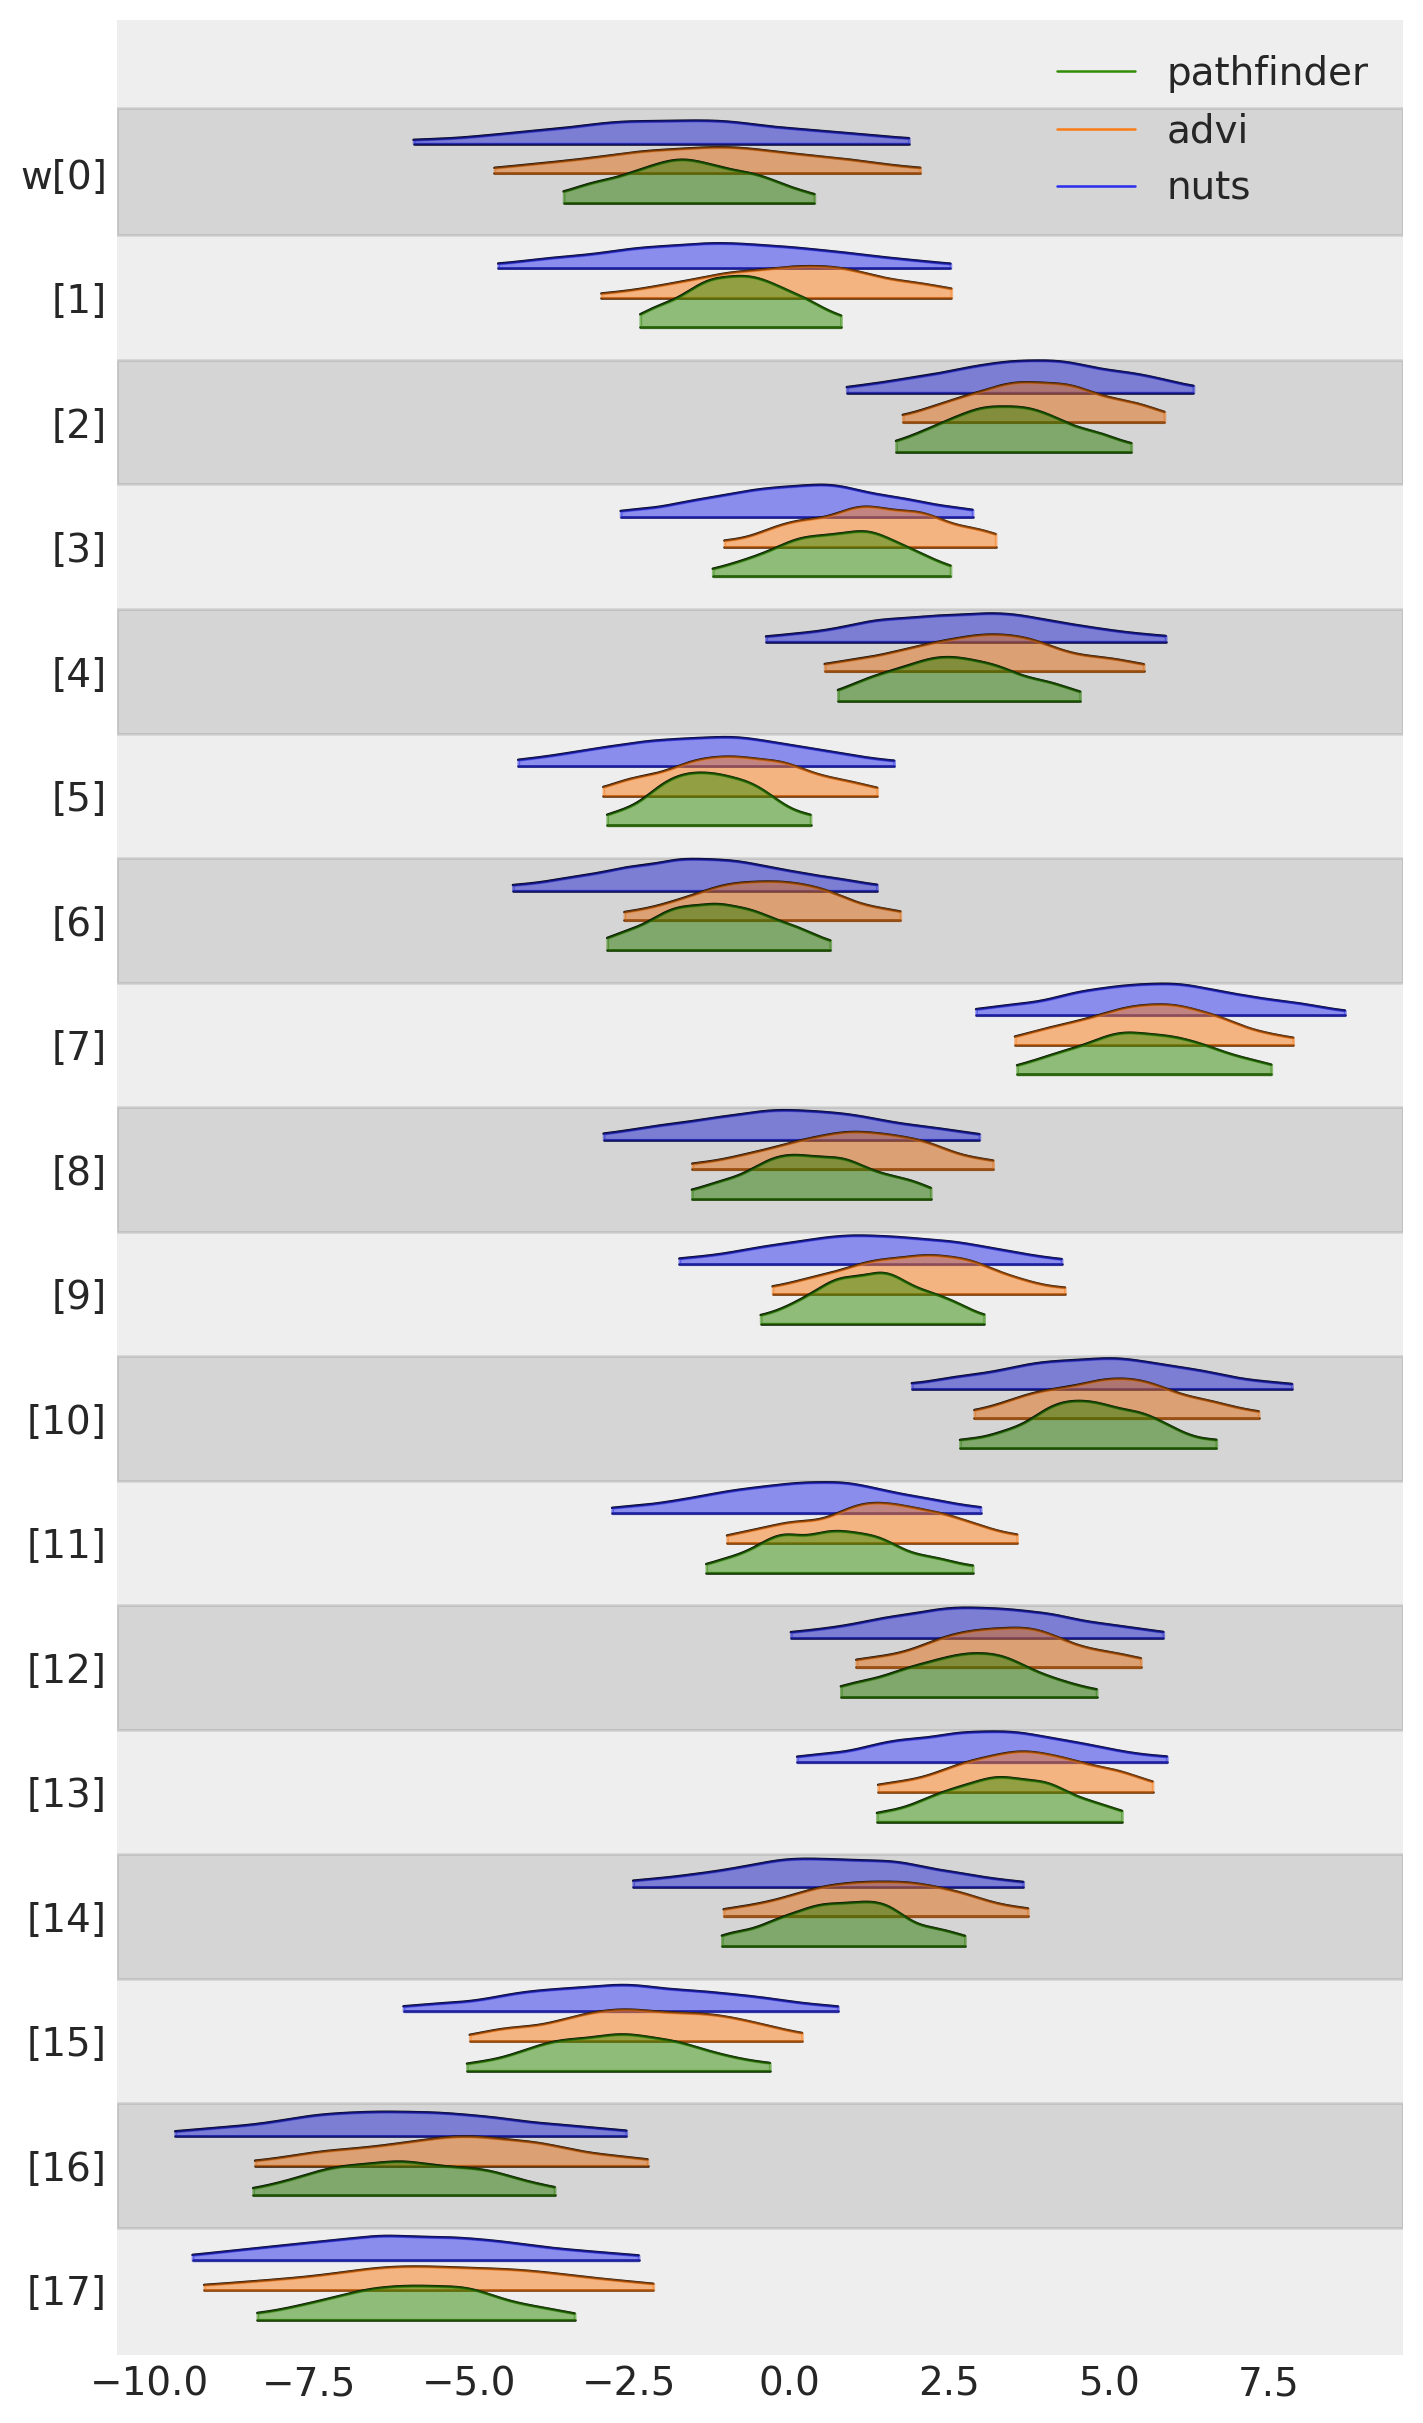

In [22]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}

az.plot_forest(
    [idata for idata in res.values()],
    model_names=[name for name in res.keys()],
    var_names="w",
    combined=True,
    figsize=(7, 12),
    kind="ridgeplot",
    ridgeplot_alpha=0.5,
);

Pathfinder appears to underestimate the variance for some of the spline weights. Not to worry, we can increase the jitter and number of paths to help with this.

In [23]:
with spline_model:
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=rng
    )

res["pf, jitter_paths"] = idata_jitter_paths_pf

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                           
                                             
  No. model parameters     20                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    9                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   20.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 67 ± std 21  
                                             
  Path Status:                               
  SUCCESS                  50                
  ELBO argmax              mean 62 ± std 21  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 1.13              
                                             
  Timing (seconds):                          
  Compile                  2.25              
  Compute                  1.43              
  Total                    3.68

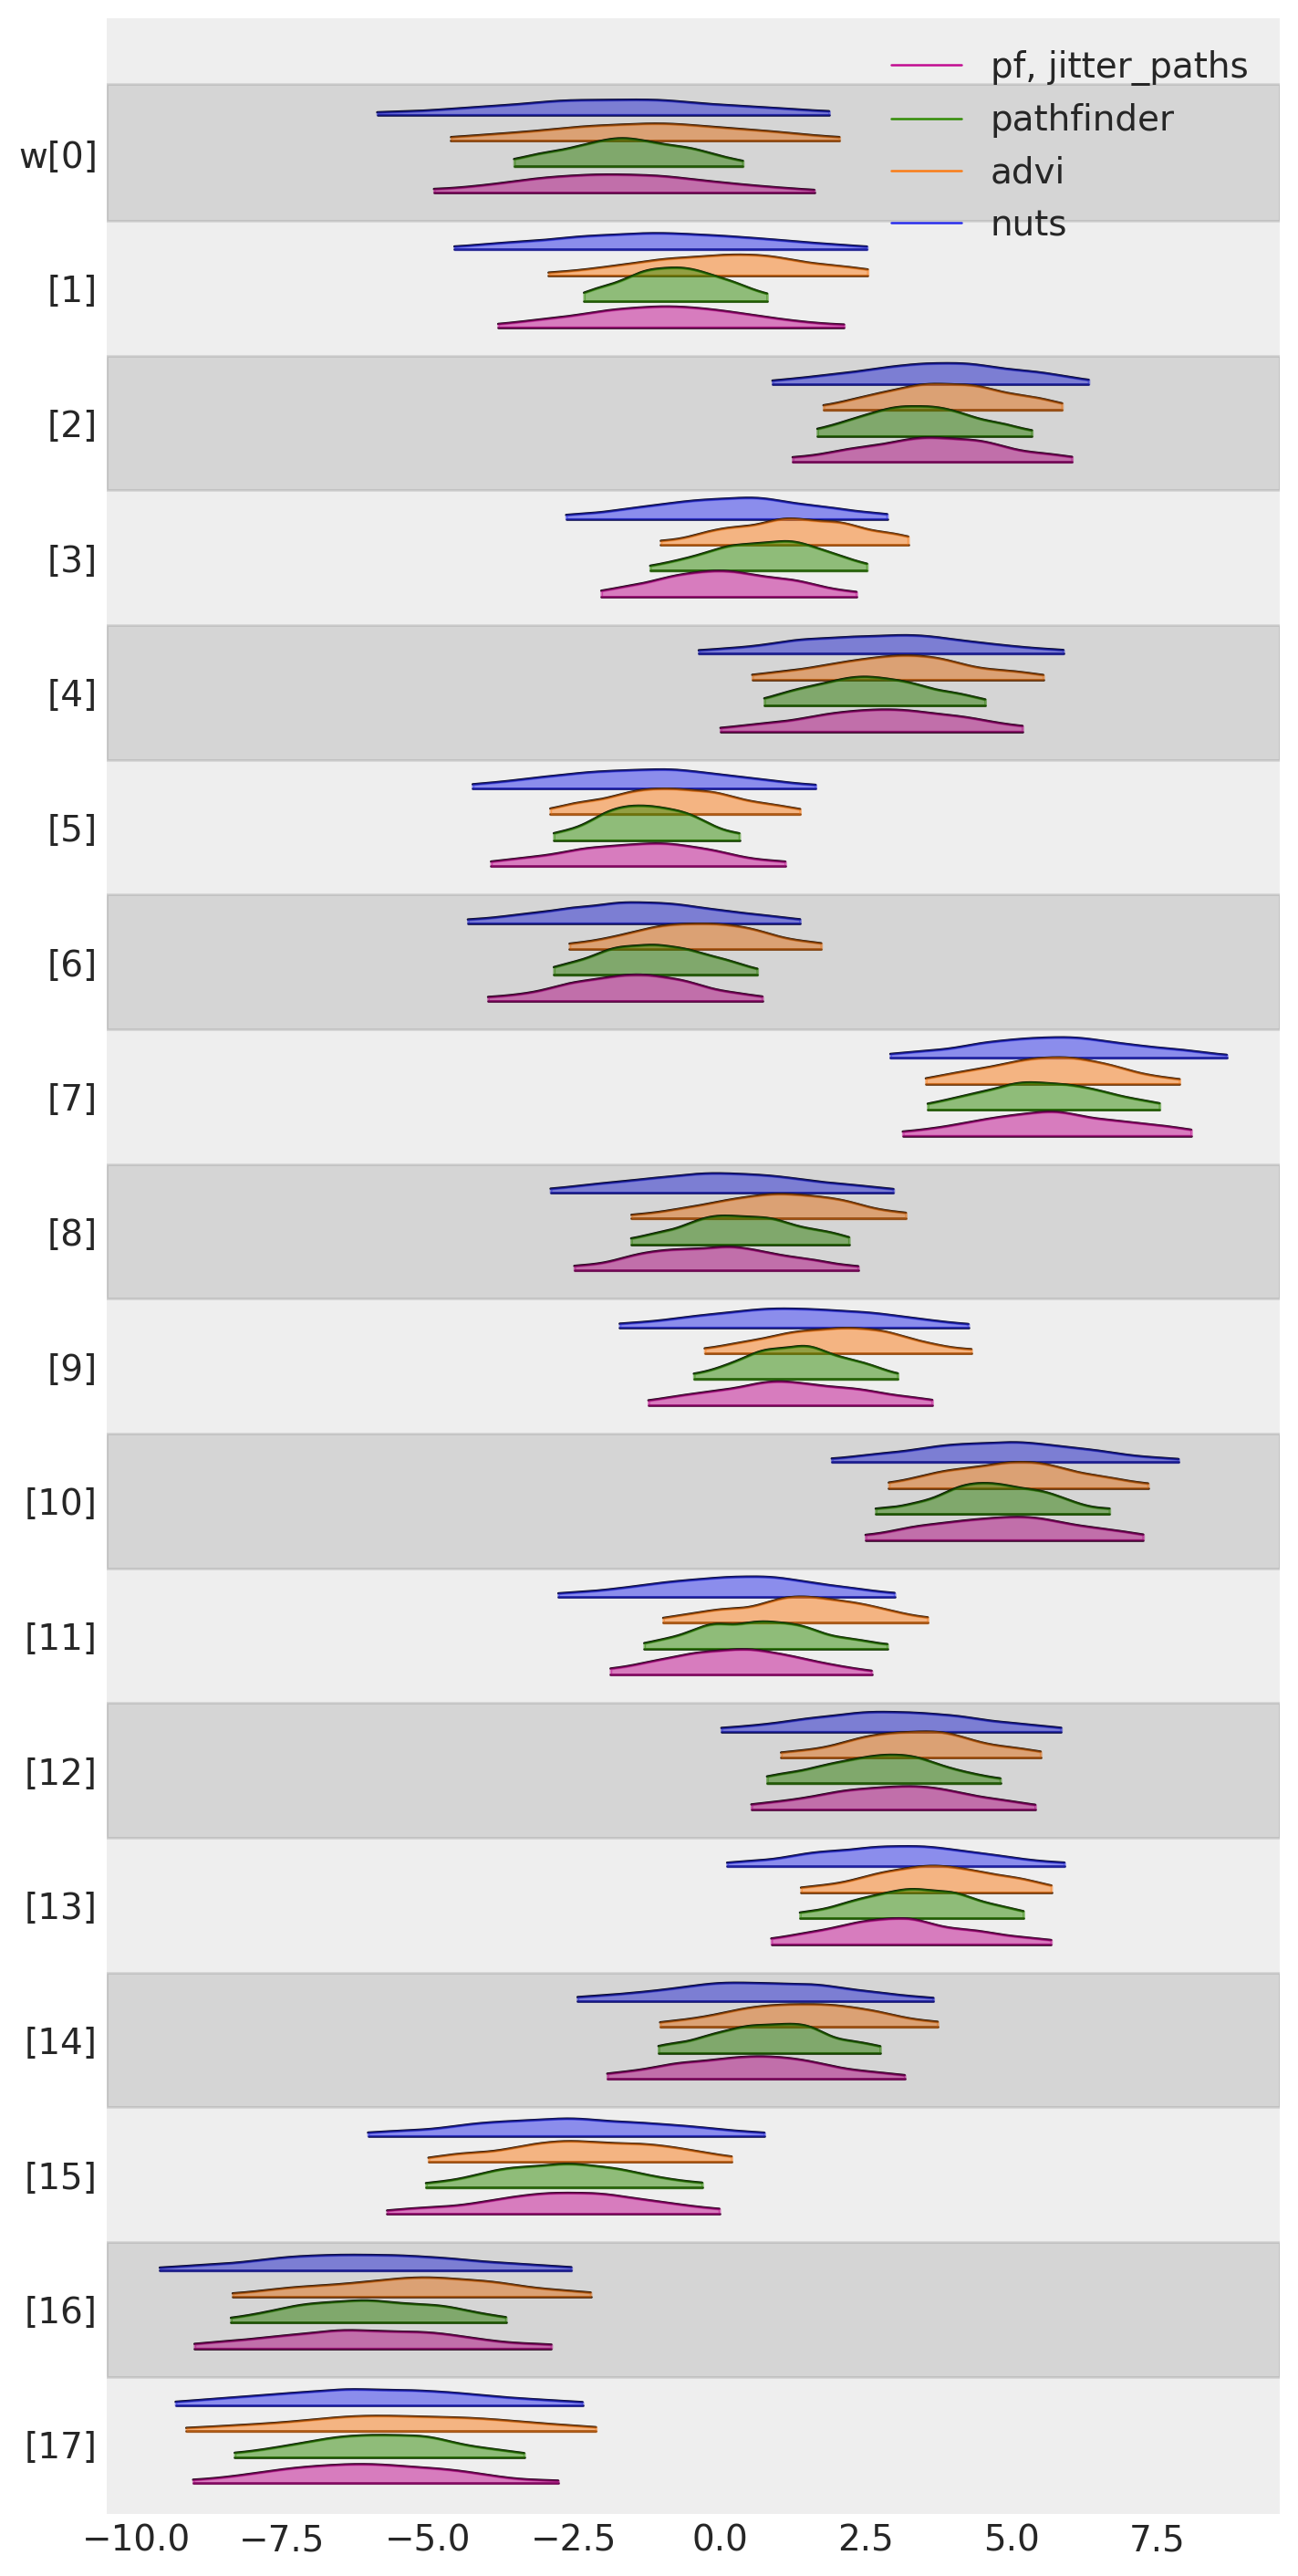

In [24]:
az.plot_forest(
    [idata for idata in res.values()],
    model_names=[name for name in res.keys()],
    var_names="w",
    combined=True,
    figsize=(7, 14),
    kind="ridgeplot",
    ridgeplot_alpha=0.5,
);

## Radon household example - Hierarchical Linear Regression

In [4]:
try:
    data = pd.read_csv(os.path.join("..", "data", "radon.csv"))
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("radon.csv"))

In [10]:
county_idx = data["county_code"].to_numpy()
floor_idx = data["floor"].astype(int).to_numpy()
log_radon = data["log_radon"].to_numpy()

coords = {"county": data.county.unique(), "level": ["basement", "floor"]}

In [16]:
with pm.Model(coords=coords) as hierarchical_model:
    # Hyperpriors
    mu = pm.Normal("mu", mu=0.0, sigma=10, dims="level")  # baseline for each level
    sigma = pm.Gamma("sigma", 2, 2, dims="level")  # scale of county variations

    # County-specific effects, constrained to sum to zero within each county
    # represents diff between floor types, relative to county's average
    county_effects = pm.ZeroSumNormal("county_effects", dims=("county", "level"))
    # Combine baseline with scaled county effects
    radon_est = mu[floor_idx] + sigma[floor_idx] * county_effects[county_idx, floor_idx]

    # Model error
    eps = pm.Gamma("eps", 2, 2)

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like",
        mu=radon_est,
        sigma=eps,
        observed=log_radon,
    )

In [17]:
with hierarchical_model:
    idata_nuts = pm.sample(nuts_sampler="nutpie", random_seed=rng)
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=rng)
    idata_psir_pf = pmx.fit(
        method="pathfinder", importance_sampling="psir", random_seed=rng
    )
    idata_pf = pmx.fit(method="pathfinder", random_seed=rng)

Output()

Finished [100%]: Average Loss = 1,074.2
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vector

Output()

Pathfinder Results                           
                                             
  No. model parameters     90                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    14                
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   2.0               
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                4                 
  L-BFGS iterations        mean 78 ± std 10  
                                             
  Path Status:                               
  SUCCESS                  4                 
  ELBO argmax              mean 38 ± std 11  
                                             
  Importance Sampling:                       
  Method                   psir              
  Pareto k                 3.15              
                                             
  Timing (seconds):                          
  Compile                  8.48              
  Compute                  0.33              
  Total                    8.81

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                           
                                             
  No. model parameters     90                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    14                
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   2.0               
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                4                 
  L-BFGS iterations        mean 71 ± std 11  
                                             
  Path Status:                               
  SUCCESS                  4                 
  ELBO argmax              mean 32 ± std 12  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 3.34              
                                             
  Timing (seconds):                          
  Compile                  1.85              
  Compute                  0.31              
  Total                    2.17

This was the point when I realised that the PSIR importance sampling was problematic! So I have made the default importance sampling to PSIS.

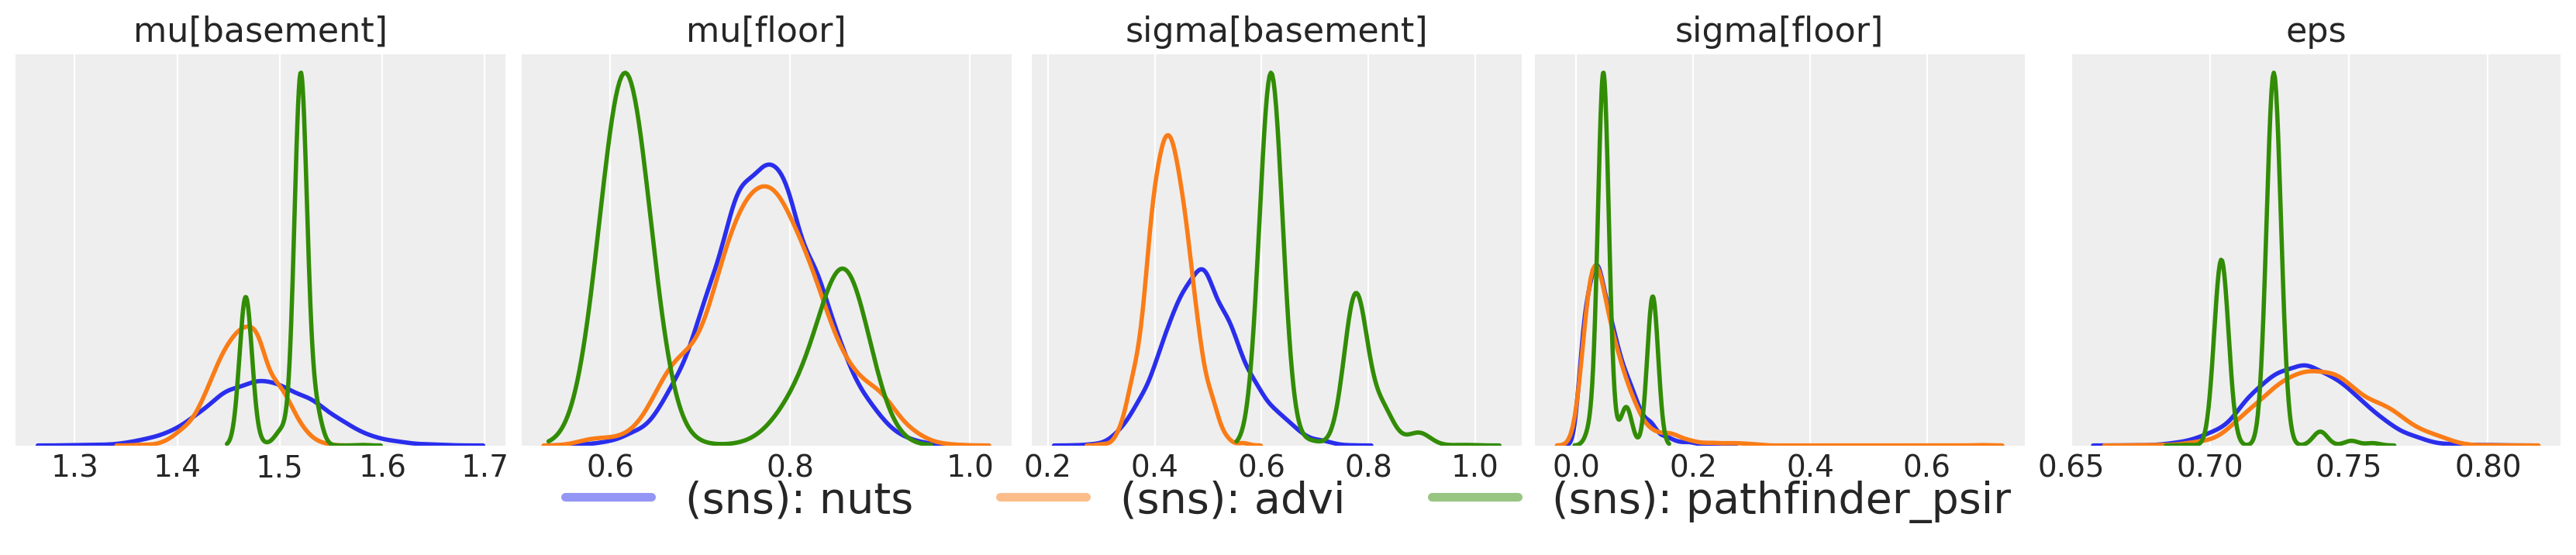

In [25]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder_psir": idata_psir_pf,
}

var_names = [
    RV.name for RV in hierarchical_model.free_RVs if "county_effects" not in RV.name
]

plot_results(res, var_names=var_names, fill=False, linewidth=2, alpha=1)

PSIR doesn't work at all. Let's see how PSIS fares.

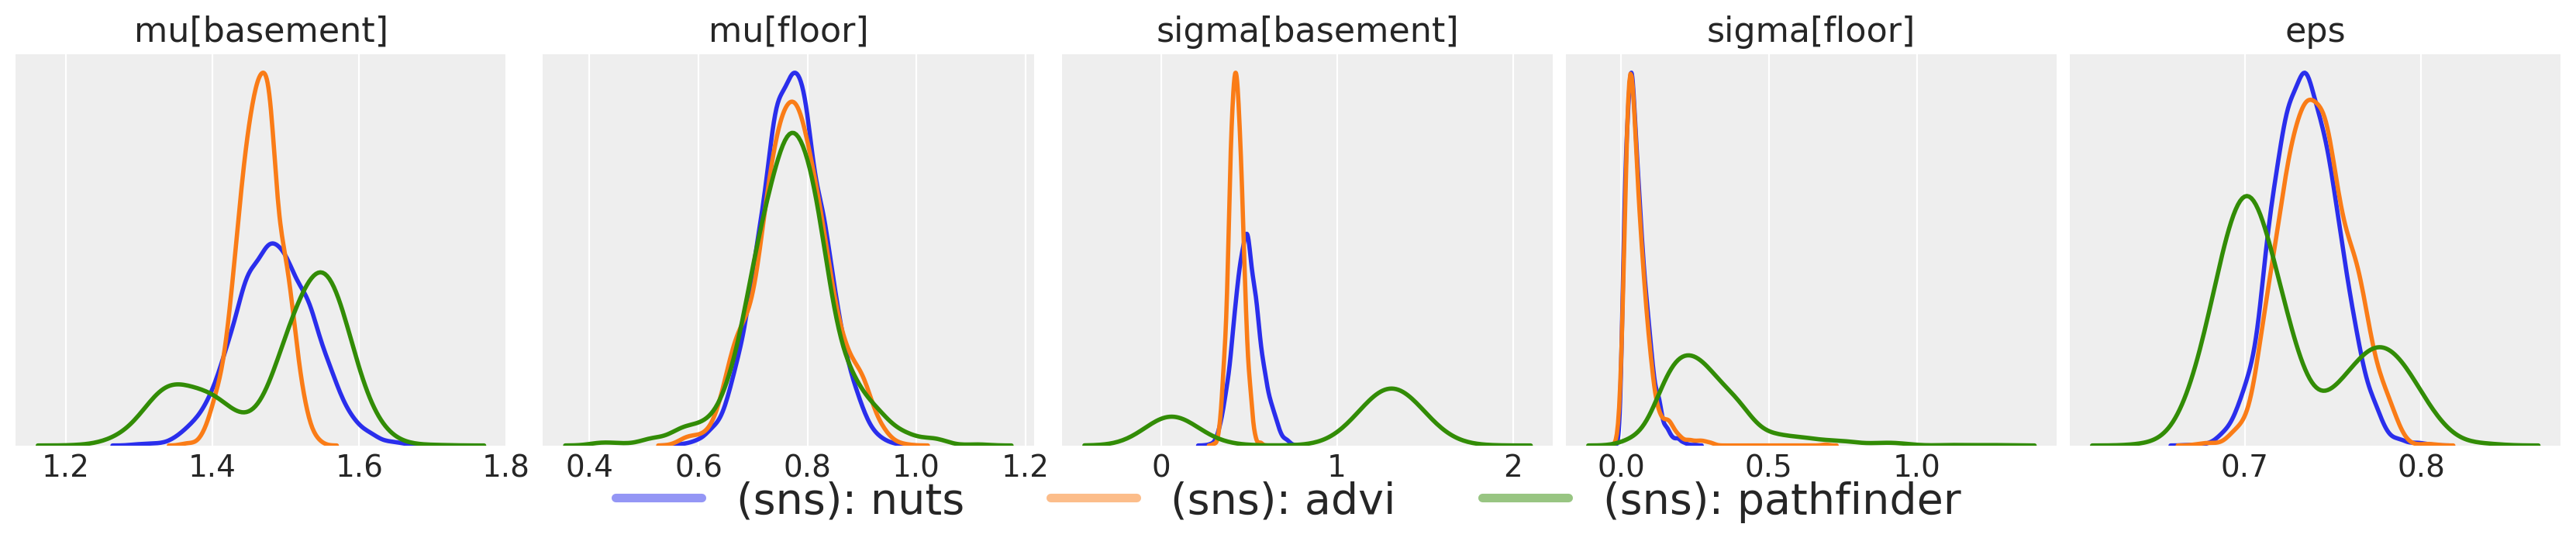

In [26]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res, var_names=var_names, fill=False, linewidth=2, alpha=1)

Better, but not good either. Let's experiment with the hyper parameters:

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/subtensor.py:2538: 
RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)

Pathfinder Results                            
                                              
  No. model parameters     90                 
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    14                 
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   20.0               
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                50                 
  L-BFGS iterations        mean 136 ± std 54  
                                              
  Path Status:                                
  SUCCESS                  50                 
  ELBO argmax              mean 103 ± std 49  
                                              
  Importance Sampling:                        
  Method                   psis               
  Pareto k                 4.58               
                                              
  Timing (seconds):                           
  Compile                  1.86               
  Compute                  6.03               
  Total                    7.89

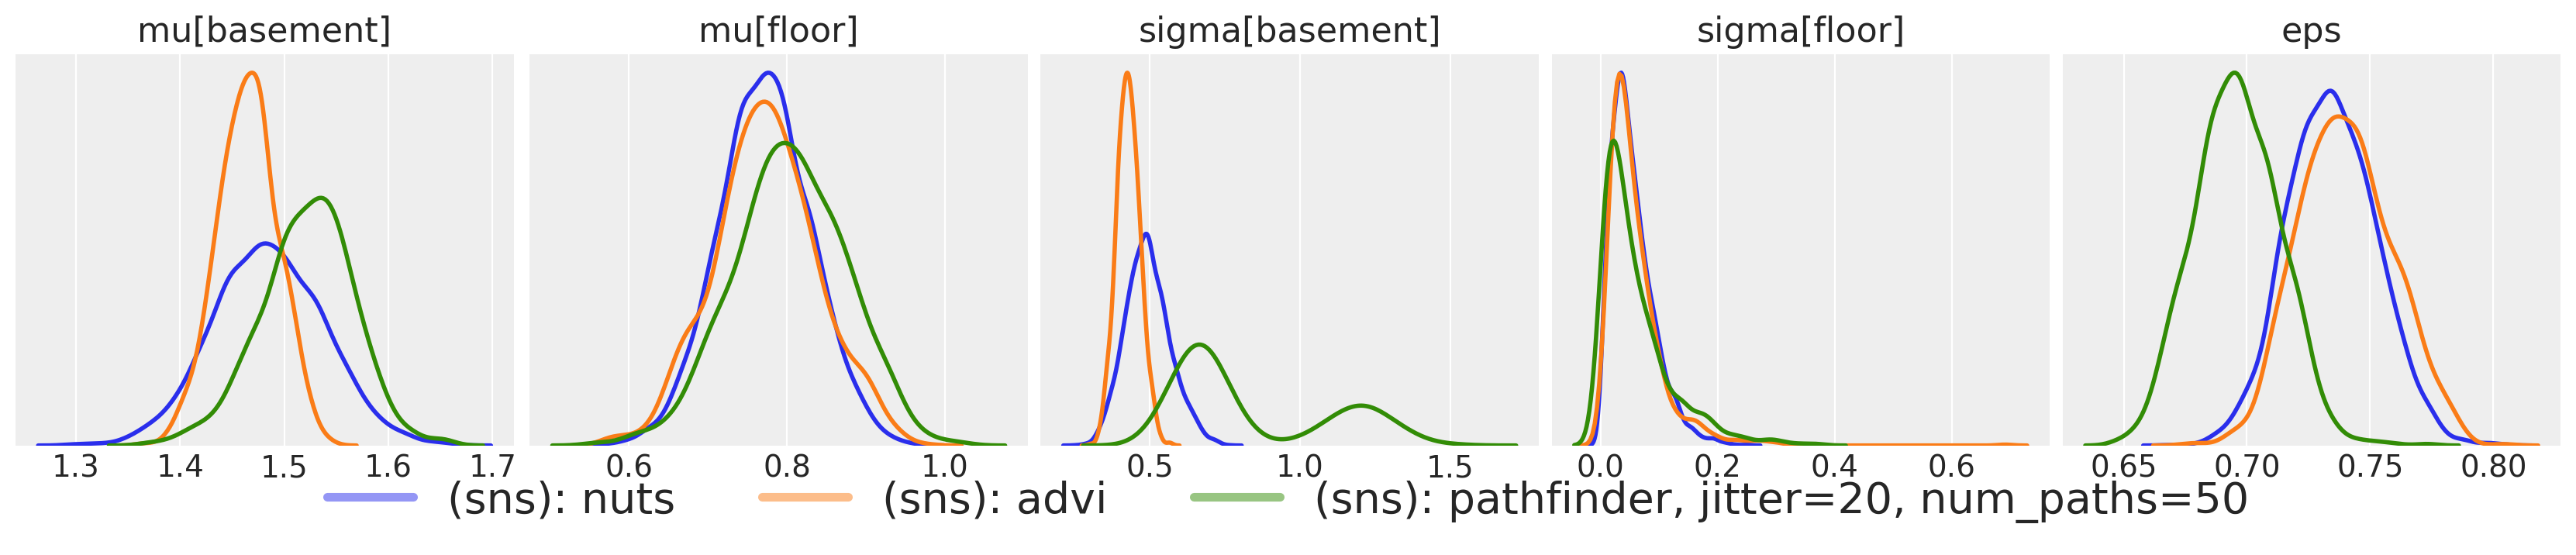

In [27]:
with hierarchical_model:
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=rng
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=20, num_paths=50": idata_jitter_paths_pf,
}
plot_results(res, var_names=var_names, fill=False, linewidth=2, alpha=1)

Better, but still a lot of bias for `sigma[basement]` and `eps`. Let's keep 50 paths, while decreasing the jitter:

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                           
                                             
  No. model parameters     90                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    14                
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   5.0               
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 90 ± std 22  
                                             
  Path Status:                               
  SUCCESS                  50                
  ELBO argmax              mean 50 ± std 22  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 4.72              
                                             
  Timing (seconds):                          
  Compile                  1.87              
  Compute                  4.54              
  Total                    6.41

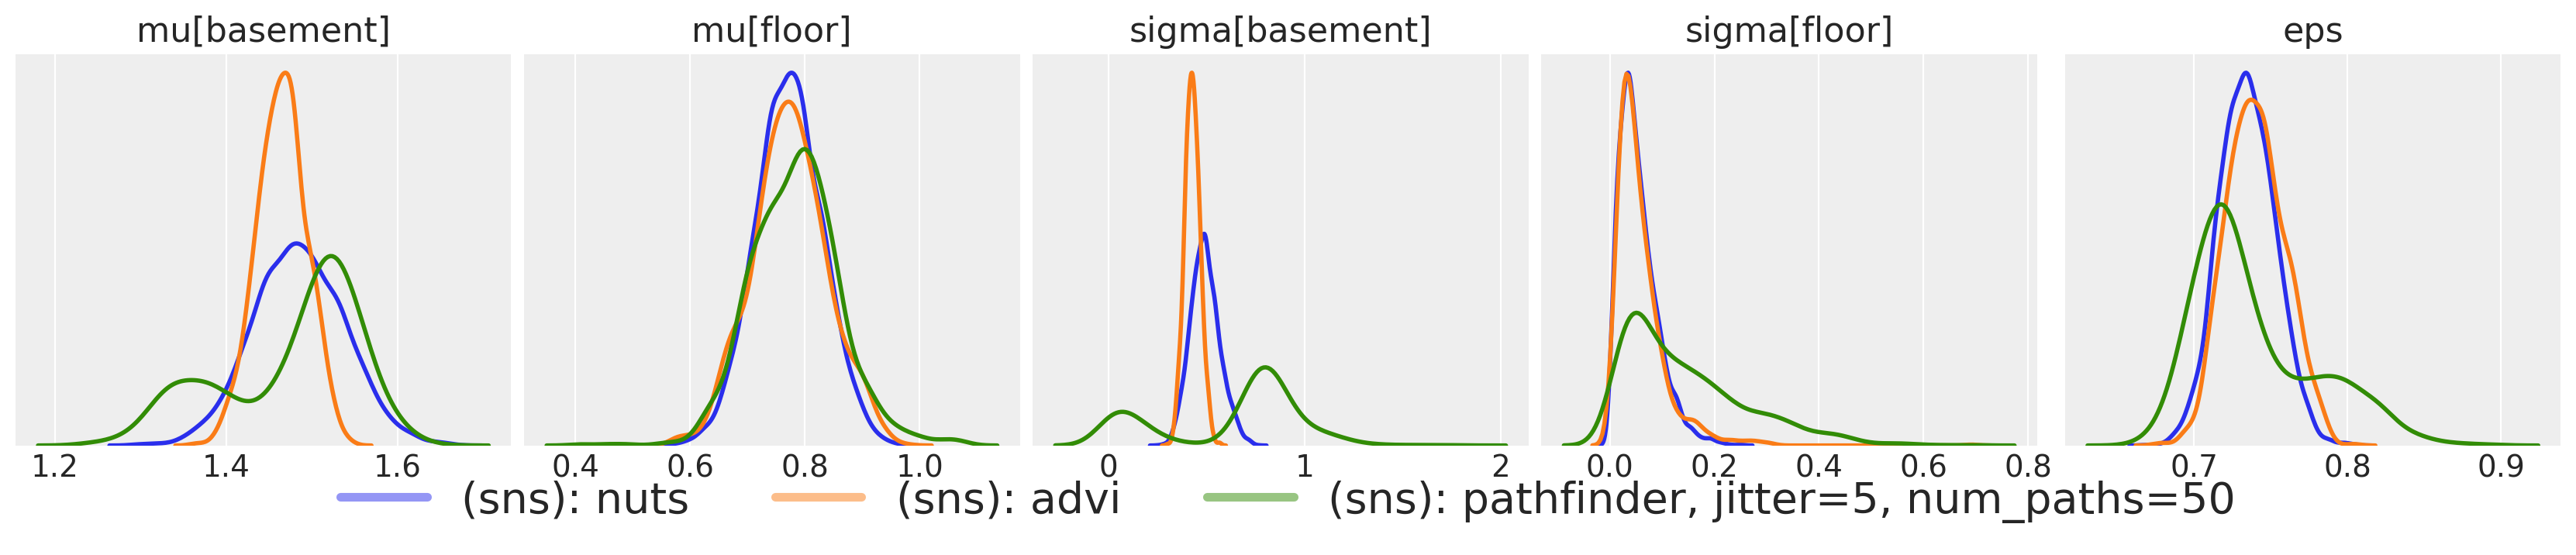

In [28]:
with hierarchical_model:
    idata_jitter_paths_pf2 = pmx.fit(
        method="pathfinder", jitter=5.0, num_paths=50, random_seed=rng
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=5, num_paths=50": idata_jitter_paths_pf2,
}
plot_results(res, var_names=var_names, fill=False, linewidth=2, alpha=1)

Still pretty bad. Let's keep decreasing the jitter, but now increase `maxcor`:

/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/Users/aandorra/miniforge3/envs/pymc_vi_course/lib/python3.13/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(


Output()

Pathfinder Results                           
                                             
  No. model parameters     90                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    30                
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   3.5               
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 83 ± std 20  
                                             
  Path Status:                               
  SUCCESS                  50                
  ELBO argmax              mean 48 ± std 23  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 3.09              
                                             
  Timing (seconds):                          
  Compile                  1.89              
  Compute                  4.92              
  Total                    6.81

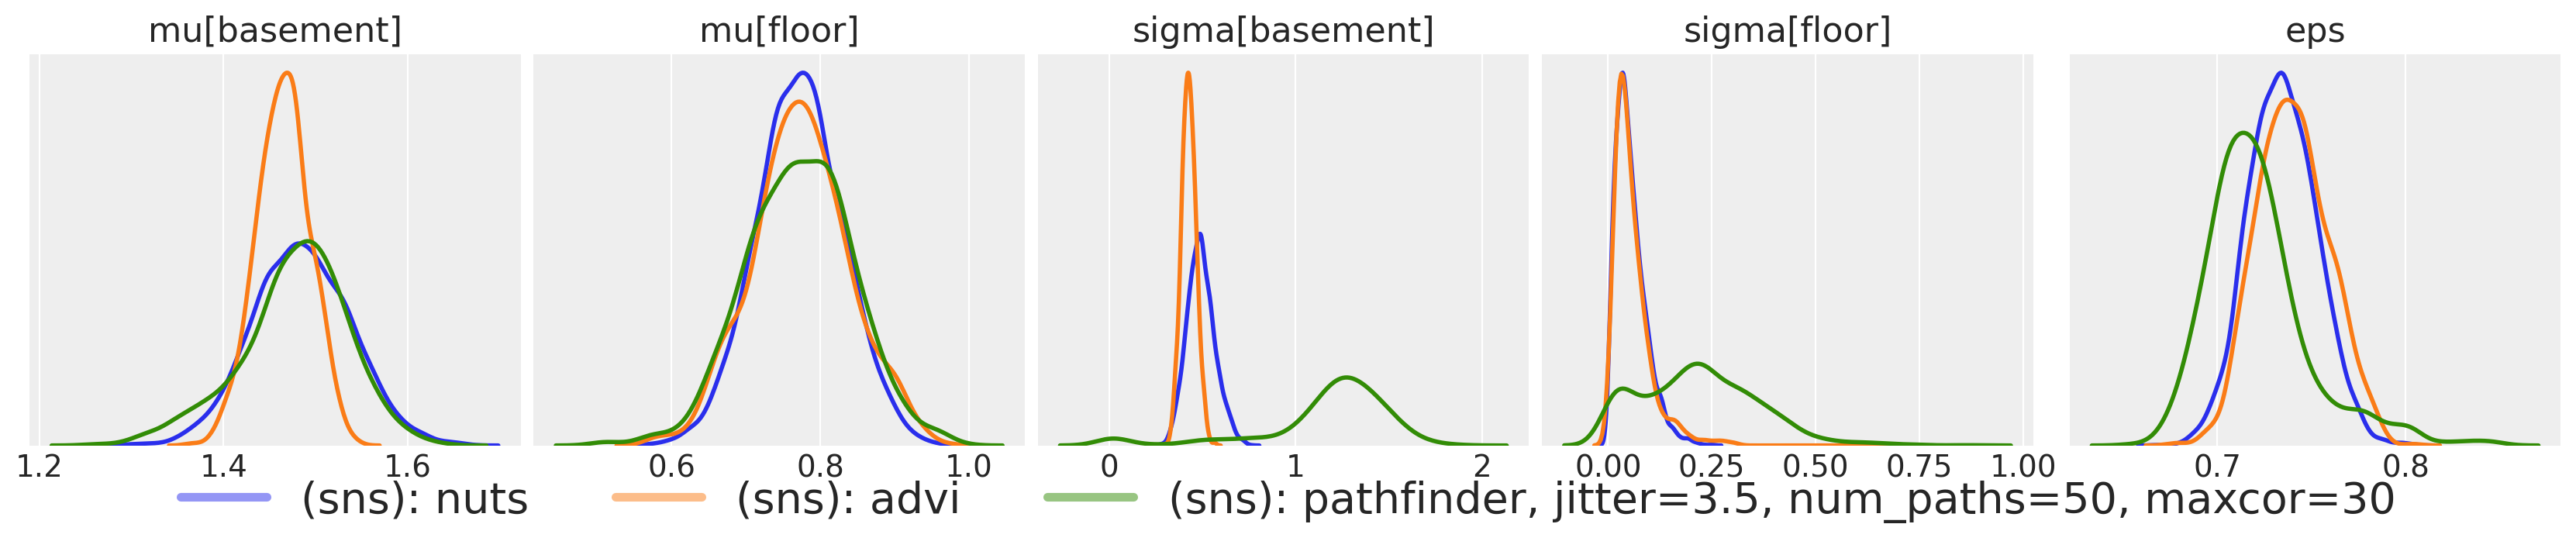

In [30]:
with hierarchical_model:
    idata_jitter_maxcor_paths_pf = pmx.fit(
        method="pathfinder", maxcor=30, jitter=3.5, num_paths=50, random_seed=rng
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=3.5, num_paths=50, maxcor=30": idata_jitter_maxcor_paths_pf,
}
plot_results(res, var_names=var_names, fill=False, linewidth=2, alpha=1)

THis example is really challenging for PF.

## Coregional GP example

In [ ]:
# CHRIS CODE HERE

In [ ]:
# ALEX WILL ADD FIT_MAP & LAPLACE ON COREGIONAL GP

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,pymc

Last updated: Sat Apr 12 2025

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.1.0

pytensor: 2.30.3
pymc    : 5.22.0

pytensor   : 2.30.3
pymc_extras: 0.2.4
preliz     : 0.16.0
numpy      : 2.2.4
seaborn    : 0.13.2
matplotlib : 3.10.1
pymc       : 5.22.0
pandas     : 2.2.3
arviz      : 0.21.0

Watermark: 2.5.0

